# 實作

我們使用"圖型搜尋與爬蟲"的資料集，繼續完成以下實作

## 資料處理

In [ ]:
# 掛載雲端硬碟

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 解壓縮URL文件檔
!unzip -q /content/drive/MyDrive/Datasets/pubfig.zip
# 解壓縮圖檔
!unzip -q /content/drive/MyDrive/Datasets/pubfig_eval.zip

In [ ]:
from glob import glob
from PIL import Image
import numpy as np
import dlib
# from mtcnn import MTCNN
import os
from tqdm import tqdm

In [ ]:
# 刪除檔案
def remove(path):
    try:
        os.remove(path)
    except:
        pass

In [ ]:
# 資料目錄
folder = "pubfig_eval"

image_paths = glob(os.path.join(folder, "*/*.jpg"))
# broken_image_paths = []
f = open("broken_list.txt", "w")
for path in tqdm(image_paths):
    # 檢查圖片是否能打開，打不開就刪除
    #print(path)
    try:
        img = np.array(Image.open(path))
    except:
        remove(path)
        continue

100%|██████████| 13193/13193 [00:39<00:00, 334.41it/s]


In [ ]:
image_paths = glob(os.path.join(folder, "*/*.jpg"))
len(image_paths)

5034

In [ ]:
# 安裝檢測器，需使用GPU
!pip install face-recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 1.1 MB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=e9d7d496913824948c6c41e211afbf9611ac5381e36eff3cb12521c7b41157a8
  Stored in directory: /root/.cache/pip/wheels/b4/4b/8f/751e99d45f089bdf366a7d3e5066db3c2b84a62e4377f534d7
Successfully built face-recognition-models


In [ ]:
# 定義檢測器
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import face_recognition

# face_detector = dlib.get_frontal_face_detector()

for path in tqdm(image_paths):
    # 檢查是否能正常檢測圖片，不能就刪除
    try:
        img = np.array(Image.open(path))
        # face_rects = face_detector(img)
        face_rects = face_recognition.face_locations(img)
    except:
        f.write(path + "\n")
        remove(path)
        continue
    # 刪除沒有人臉的圖片
    if len(face_rects) == 0:
        remove(path)
        continue
    # for rect in face_rects:
    # (xmin,ymin),(xmax,ymax)
    # face = Image.fromarray(img[ymin:ymax, xmin:xmax]).show()
    # print("rect")
f.close()

100%|██████████| 5034/5034 [22:53<00:00,  3.66it/s]


In [ ]:
image_paths = glob(os.path.join(folder, "*/*.jpg"))
len(image_paths)

4103

In [ ]:
# 提取人臉

import pandas as pd
import os

# from PIL import Image
import numpy as np
import re
import time
import cv2
from tqdm import tqdm

path = "pubfig/dev_urls.txt"
folder = "pubfig_eval"
# 第一行是注释，第二行标题前面有个#号
df = pd.read_table(path, header=1)
cols = df.columns[1:]
df = df.drop(["md5sum"], axis=1)
df.columns = cols
# print(df.head())
df.head()

,person,imagenum,url,rect,md5sum
0,Abhishek Bachan,1,http://1.bp.blogspot.com/_Y7rzCyUABeI/SNIltEyE...,"183,60,297,174",f533da9fbd1c770428c8961f3fa48950
1,Abhishek Bachan,2,http://1.bp.blogspot.com/_v9nTKD7D57Q/SQ3HUQHs...,"49,71,143,165",e36a8b24f0761ec75bdc0489d8fd570b
2,Abhishek Bachan,3,http://2.bp.blogspot.com/_v9nTKD7D57Q/SL5KwcwQ...,"32,68,142,178",583608783525c2ac419b41e538a6925d
3,Abhishek Bachan,4,http://4.bp.blogspot.com/_J5lA45Wlfz0/SWLP0VF6...,"183,76,289,182",c1faf35ac21df75381be5b4b16a0991f
4,Abhishek Bachan,7,http://bp3.blogger.com/_yM6QBGZjQTU/RiygrkUDQ_...,"123,63,227,167",bc71ac6b1a62e87e262d610009778fac


In [ ]:
len(df)

16336

In [ ]:
# cnt = 0
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    src_folder = os.path.join(folder, row["person"])
    src_path = os.path.join(
        src_folder, row["person"] + str(row["imagenum"]) + ".jpg"
    )
    # 替換掉上級資料夾的名稱
    target_folder = re.sub("pubfig", "pubfig_faces", src_folder)
    target_path = re.sub("pubfig", "pubfig_faces", src_path)

    # 如果原始檔案存在，則在目的檔案中，存入圖片
    if os.path.exists(src_path):
        # img = np.array(Image.open(src_path).convert("BGR"))
        img = cv2.imread(src_path)
        # 檢測框
        rect = row["rect"]
        # xmin,ymin,xmax,ymax
        rect = [int(r) for r in rect.split(",")]
        # 擷取人臉
        face = img[rect[1] : rect[3], rect[0] : rect[2], :]
        # face = Image.fromarray(face)
        # print(src_path)
        # print(rect)
        # face.show()
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)
        # face.save(target_path)
        # cv2.imshow("face", face)
        try:
          cv2.imwrite(target_path, face)
        except:
          pass
        # if cnt > 10:
        # break
        # cnt += 1

100%|██████████| 16336/16336 [00:35<00:00, 464.82it/s]


In [ ]:
image_paths = glob(os.path.join('pubfig_faces_eval', "*/*.jpg"))
len(image_paths)

4068

## 自動編碼器

### 參數設定

In [ ]:
import torch


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
size = 128
batch_size = 16
# EPOCH_LR = [(30,0.01),(30,0.001)]
epoch_lr = [(30, 0.01), (30, 0.001), (50, 0.001)]
checkpoint = "./"
data_folder = "pubfig_faces_eval"

### 建立AE模型

In [ ]:
from torch import nn
import torch
from torchvision.models import resnet18

# from config import device

#### 解碼器

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(DecoderBlock, self).__init__()
        # 卷積層
        self.conv1 = nn.Conv2d(
            in_channels, in_channels // 4, kernel_size, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nn.ReLU(inplace=True)
        # 反卷積
        self.deconv = nn.ConvTranspose2d(
            in_channels // 4,
            in_channels // 4,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nn.ReLU(inplace=True)
        # 卷積層
        self.conv3 = nn.Conv2d(
            in_channels // 4,
            out_channels,
            kernel_size=kernel_size,
            padding=1,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu3 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.deconv(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        return x

#### 編碼器

編碼器直接使用預訓練的ResNet架構即可。

#### 組成AE

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(AutoEncoder, self).__init__()
        base = resnet18(pretrained=pretrained)

        # 因為是黑白圖片，只有一個通道，所以需要重新定義第一層
        # self.firstconv = base.conv1
        self.firstconv = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.firstbn = base.bn1
        self.firstrelu = base.relu
        self.firstmaxpool = base.maxpool
        self.encoder1 = base.layer1
        self.encoder2 = base.layer2
        self.encoder3 = base.layer3
        self.encoder4 = base.layer4

        # 解碼器輸出通道數量
        out_channels = [64, 128, 256, 512]
        # 建立解碼區塊
        self.center = DecoderBlock(
            in_channels=out_channels[3],
            out_channels=out_channels[3],
            kernel_size=3,
        )
        self.decoder4 = DecoderBlock(
            in_channels=out_channels[3],
            out_channels=out_channels[2],
            kernel_size=3,
        )
        self.decoder3 = DecoderBlock(
            in_channels=out_channels[2],
            out_channels=out_channels[1],
            kernel_size=3,
        )
        self.decoder2 = DecoderBlock(
            in_channels=out_channels[1],
            out_channels=out_channels[0],
            kernel_size=3,
        )
        self.decoder1 = DecoderBlock(
            in_channels=out_channels[0],
            out_channels=out_channels[0],
            kernel_size=3,
        )
        # 透過最後兩層卷積，來將輸出整理成圖片對應的尺寸
        self.finalconv = nn.Sequential(
            nn.Conv2d(out_channels[0], 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.1, False),
            nn.Conv2d(32, num_classes, 1),
        )

    def forward(self, x, extract_feature=False):
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)

        # 編碼器
        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.encoder4(x)

        # 在執行壓縮的時候，可以直接將extract_feature設定為True
        # 就可以得到壓縮後的圖片矩陣了
        if extract_feature:
            return x

        # 解碼器
        x = self.center(x)
        x = self.decoder4(x)
        x = self.decoder3(x)
        x = self.decoder2(x)
        x = self.decoder1(x)
        # 整理輸出
        f = self.finalconv(x)
        return f

In [ ]:
if __name__ == "__main__":
    from torchsummary import summary

    inp = torch.ones((1, 1, 128, 128)).to(device)
    net = AutoEncoder().to(device)
    out = net(inp, extract_feature=False)
    print(out.shape)
    # summary(net, (1, 224, 224))

torch.Size([1, 1, 128, 128])


### 建立資料集

AE屬於無監督學習演算法，只需訓練一個從圖片自身到自身的映射。因此，建構的資料集，只須返回圖片自身。

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
# from config import data_folder, batch_size, size
from glob import glob
import os.path as osp
from PIL import Image
from torchvision import transforms

In [ ]:
class Data(Dataset):
    def __init__(self, folder=data_folder, subset="train", transform=None):
        img_paths = glob(osp.join(folder, "*/*.jpg"))
        train_paths, test_paths = train_test_split(
            img_paths, test_size=0.2, random_state=10
        )
        # 訓練集
        if subset == "train":
            self.img_paths = train_paths
        # 測試集
        else:
            self.img_paths = test_paths
        # 如果沒有定義transform，則使用預設的transform
        if transform is None:
            self.transform = transforms.Compose(
                [transforms.Resize((size, size)), transforms.ToTensor()]
            )
        else:
            self.transform = transform

    def __getitem__(self, index):
        # 圖片需要轉為黑白
        # print(self.img_paths[index])
        img = Image.open(self.img_paths[index]).convert("L")
        img = self.transform(img)
        return img, img

    def __len__(self):
        return len(self.img_paths)

In [ ]:
transform = transforms.Compose(
    [
        # transforms.RandomRotation(15),
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ]
)

train_data = Data(subset="train", transform=transform)
val_data = Data(subset="test")
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size * 2, shuffle=True)

如果模型的訓練結果不夠理想，則可以增加資料增強方法，但是需要保證原圖片和目標圖片，轉換方法完全相同。

### 模型訓練

訓練過程中，使用L1損失或MSE損失都可以。

In [ ]:
from torch import nn, optim
import torch
import os.path as osp
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

# from data import train_loader, val_loader
# from auto_encoder import AutoEncoder
# from config import BATCH_SIZE, EPOCH_LR, device, CHECKPOINT

In [ ]:
def train():
    # 將模型轉入GPU
    net = AutoEncoder(pretrained=True).to(device)
    criteron = nn.L1Loss()
    # 模型保存位置
    ckpt = osp.join(checkpoint, "net.pth")
    writer = SummaryWriter("log")
    # 檢查是否有可用模型，有則載入
    if osp.exists(ckpt):
        net.load_state_dict(torch.load(ckpt))

    for n, (num_epoch, lr) in enumerate(epoch_lr):
        optimizer = optim.Adam(net.parameters(), lr=lr)
        for epoch in range(num_epoch):
            epoch_loss = 0.0
            for i, (src, target) in tqdm(
                enumerate(train_loader), total=len(train_loader)
            ):
                optimizer.zero_grad()
                # 雖然AE中的src和target是一樣的圖片
                # 但是為了適用更多的任務，還是將src和target進行了區分
                src, target = src.to(device), target.to(device)
                out = net(src)
                loss = criteron(out, target)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            print(
                "epoch: {} epoch_loss {}".format(
                    sum([e[0] for e in epoch_lr[:n]]) + epoch,
                    epoch_loss / len(train_loader),
                )
            )
            # 將損失加入TensorBoard
            writer.add_scalar(
                "epoch_loss",
                epoch_loss / len(train_loader),
                sum([e[0] for e in epoch_lr[:n]]) + epoch,
            )
            # 無梯度模式，快速驗證
            with torch.no_grad():
                val_loss = 0.0
                for i, (src, target) in tqdm(
                    enumerate(val_loader), total=len(val_loader)
                ):
                    src, target = src.to(device), target.to(device)
                    out = net(src)
                    loss = criteron(out, target)
                    val_loss += loss.item()
            print(
                "val: {} val_loss {}".format(
                    sum([e[0] for e in epoch_lr[:n]]) + epoch,
                    val_loss / len(val_loader),
                )
            )
            # 將損失加入TensorBoard
            writer.add_scalar(
                "val_loss",
                val_loss / len(val_loader),
                sum([e[0] for e in epoch_lr[:n]]) + epoch,
            )
            torch.save(net.state_dict(), ckpt)
    # 訓練結束後，關閉writer
    writer.close()

In [ ]:
if __name__ == "__main__":
    train()

100%|██████████| 204/204 [00:21<00:00,  9.68it/s]


epoch: 0 epoch_loss 0.19735871087394508


100%|██████████| 26/26 [00:02<00:00, 12.81it/s]


val: 0 val_loss 0.15746045743043607


100%|██████████| 204/204 [00:21<00:00,  9.39it/s]


epoch: 1 epoch_loss 0.12377701929825194


100%|██████████| 26/26 [00:02<00:00, 12.70it/s]


val: 1 val_loss 0.10430750909906167


100%|██████████| 204/204 [00:21<00:00,  9.50it/s]


epoch: 2 epoch_loss 0.10034601112791136


100%|██████████| 26/26 [00:02<00:00, 12.80it/s]


val: 2 val_loss 0.0917121793788213


100%|██████████| 204/204 [00:21<00:00,  9.59it/s]


epoch: 3 epoch_loss 0.0943772731093215


100%|██████████| 26/26 [00:02<00:00, 12.91it/s]


val: 3 val_loss 0.08954672916577412


100%|██████████| 204/204 [00:21<00:00,  9.59it/s]


epoch: 4 epoch_loss 0.08809844488460644


100%|██████████| 26/26 [00:02<00:00, 12.83it/s]


val: 4 val_loss 0.08080056223731774


100%|██████████| 204/204 [00:21<00:00,  9.52it/s]


epoch: 5 epoch_loss 0.08234337841471036


100%|██████████| 26/26 [00:02<00:00, 12.79it/s]


val: 5 val_loss 0.08423367171333386


100%|██████████| 204/204 [00:21<00:00,  9.52it/s]


epoch: 6 epoch_loss 0.08143312933252138


100%|██████████| 26/26 [00:02<00:00, 12.83it/s]


val: 6 val_loss 0.07702305827003258


100%|██████████| 204/204 [00:21<00:00,  9.59it/s]


epoch: 7 epoch_loss 0.07643874400459669


100%|██████████| 26/26 [00:02<00:00, 12.82it/s]


val: 7 val_loss 0.07016035685172448


100%|██████████| 204/204 [00:21<00:00,  9.57it/s]


epoch: 8 epoch_loss 0.07676499884794741


100%|██████████| 26/26 [00:02<00:00, 12.81it/s]


val: 8 val_loss 0.07623786421922538


100%|██████████| 204/204 [00:21<00:00,  9.39it/s]


epoch: 9 epoch_loss 0.07435690682819661


100%|██████████| 26/26 [00:02<00:00, 12.88it/s]


val: 9 val_loss 0.0671963753321996


100%|██████████| 204/204 [00:21<00:00,  9.55it/s]


epoch: 10 epoch_loss 0.07217022537381626


100%|██████████| 26/26 [00:02<00:00, 12.80it/s]


val: 10 val_loss 0.0686567325431567


100%|██████████| 204/204 [00:21<00:00,  9.54it/s]


epoch: 11 epoch_loss 0.06997778887550037


100%|██████████| 26/26 [00:02<00:00, 12.74it/s]


val: 11 val_loss 0.06724969928081219


100%|██████████| 204/204 [00:21<00:00,  9.55it/s]


epoch: 12 epoch_loss 0.06970168703107857


100%|██████████| 26/26 [00:02<00:00, 12.71it/s]


val: 12 val_loss 0.06320649643356983


100%|██████████| 204/204 [00:21<00:00,  9.56it/s]


epoch: 13 epoch_loss 0.06786997333242029


100%|██████████| 26/26 [00:02<00:00, 12.67it/s]


val: 13 val_loss 0.07301478546399337


100%|██████████| 204/204 [00:21<00:00,  9.58it/s]


epoch: 14 epoch_loss 0.06998305990561551


100%|██████████| 26/26 [00:02<00:00, 12.84it/s]


val: 14 val_loss 0.0637593212035986


100%|██████████| 204/204 [00:21<00:00,  9.58it/s]


epoch: 15 epoch_loss 0.06471637106847529


100%|██████████| 26/26 [00:02<00:00, 12.82it/s]


val: 15 val_loss 0.07441925028195748


100%|██████████| 204/204 [00:21<00:00,  9.56it/s]


epoch: 16 epoch_loss 0.06402930241151183


100%|██████████| 26/26 [00:02<00:00, 12.82it/s]


val: 16 val_loss 0.059596221607465014


100%|██████████| 204/204 [00:21<00:00,  9.56it/s]


epoch: 17 epoch_loss 0.06346814995448963


100%|██████████| 26/26 [00:02<00:00, 12.77it/s]


val: 17 val_loss 0.06088446625150167


100%|██████████| 204/204 [00:21<00:00,  9.54it/s]


epoch: 18 epoch_loss 0.06521304824626913


100%|██████████| 26/26 [00:02<00:00, 12.69it/s]


val: 18 val_loss 0.06326915925511947


100%|██████████| 204/204 [00:21<00:00,  9.55it/s]


epoch: 19 epoch_loss 0.0626502723487861


100%|██████████| 26/26 [00:02<00:00, 12.72it/s]


val: 19 val_loss 0.0591542270894234


100%|██████████| 204/204 [00:21<00:00,  9.46it/s]


epoch: 20 epoch_loss 0.061340501002382995


100%|██████████| 26/26 [00:02<00:00, 11.84it/s]


val: 20 val_loss 0.059759287880017206


100%|██████████| 204/204 [00:21<00:00,  9.58it/s]


epoch: 21 epoch_loss 0.06095165414187838


100%|██████████| 26/26 [00:02<00:00, 12.77it/s]


val: 21 val_loss 0.05843459958067307


100%|██████████| 204/204 [00:21<00:00,  9.57it/s]


epoch: 22 epoch_loss 0.06233004297988087


100%|██████████| 26/26 [00:02<00:00, 12.70it/s]


val: 22 val_loss 0.05819962746821917


100%|██████████| 204/204 [00:21<00:00,  9.56it/s]


epoch: 23 epoch_loss 0.06150815131909707


100%|██████████| 26/26 [00:02<00:00, 12.81it/s]


val: 23 val_loss 0.05766307849150438


100%|██████████| 204/204 [00:21<00:00,  9.57it/s]


epoch: 24 epoch_loss 0.060670850122822265


100%|██████████| 26/26 [00:02<00:00, 12.85it/s]


val: 24 val_loss 0.05364289908454968


100%|██████████| 204/204 [00:21<00:00,  9.57it/s]


epoch: 25 epoch_loss 0.05966085403719369


100%|██████████| 26/26 [00:02<00:00, 12.83it/s]


val: 25 val_loss 0.05389497787333452


100%|██████████| 204/204 [00:21<00:00,  9.56it/s]


epoch: 26 epoch_loss 0.05858975102869319


100%|██████████| 26/26 [00:02<00:00, 12.79it/s]


val: 26 val_loss 0.05928185381568395


100%|██████████| 204/204 [00:21<00:00,  9.56it/s]


epoch: 27 epoch_loss 0.05966389772719612


100%|██████████| 26/26 [00:02<00:00, 12.86it/s]


val: 27 val_loss 0.052438559727026865


100%|██████████| 204/204 [00:21<00:00,  9.57it/s]


epoch: 28 epoch_loss 0.06086321195185769


100%|██████████| 26/26 [00:02<00:00, 12.86it/s]


val: 28 val_loss 0.05384260344390686


100%|██████████| 204/204 [00:21<00:00,  9.58it/s]


epoch: 29 epoch_loss 0.057669636702128484


100%|██████████| 26/26 [00:02<00:00, 12.87it/s]


val: 29 val_loss 0.05320851748379377


100%|██████████| 204/204 [00:21<00:00,  9.60it/s]


epoch: 30 epoch_loss 0.05411768005247794


100%|██████████| 26/26 [00:02<00:00, 12.85it/s]


val: 30 val_loss 0.04992591589689255


100%|██████████| 204/204 [00:21<00:00,  9.55it/s]


epoch: 31 epoch_loss 0.05219274350241119


100%|██████████| 26/26 [00:02<00:00, 12.82it/s]


val: 31 val_loss 0.05116009970123951


100%|██████████| 204/204 [00:21<00:00,  9.43it/s]


epoch: 32 epoch_loss 0.05443831593455637


100%|██████████| 26/26 [00:02<00:00, 12.84it/s]


val: 32 val_loss 0.04991307224218662


100%|██████████| 204/204 [00:21<00:00,  9.56it/s]


epoch: 33 epoch_loss 0.05278301602412088


100%|██████████| 26/26 [00:02<00:00, 12.73it/s]


val: 33 val_loss 0.04862746596336365


100%|██████████| 204/204 [00:21<00:00,  9.55it/s]


epoch: 34 epoch_loss 0.05190502707937769


100%|██████████| 26/26 [00:02<00:00, 12.88it/s]


val: 34 val_loss 0.04800434926381478


100%|██████████| 204/204 [00:21<00:00,  9.56it/s]


epoch: 35 epoch_loss 0.05206294828916297


100%|██████████| 26/26 [00:02<00:00, 12.65it/s]


val: 35 val_loss 0.04882774559351114


100%|██████████| 204/204 [00:21<00:00,  9.54it/s]


epoch: 36 epoch_loss 0.052852580999480744


100%|██████████| 26/26 [00:02<00:00, 12.72it/s]


val: 36 val_loss 0.05092380597041203


100%|██████████| 204/204 [00:21<00:00,  9.56it/s]


epoch: 37 epoch_loss 0.051353826844955194


100%|██████████| 26/26 [00:02<00:00, 12.85it/s]


val: 37 val_loss 0.05077566263767389


100%|██████████| 204/204 [00:21<00:00,  9.57it/s]


epoch: 38 epoch_loss 0.052305989113508485


100%|██████████| 26/26 [00:02<00:00, 12.76it/s]


val: 38 val_loss 0.05138611865158264


100%|██████████| 204/204 [00:21<00:00,  9.57it/s]


epoch: 39 epoch_loss 0.0520580178309305


100%|██████████| 26/26 [00:02<00:00, 12.85it/s]


val: 39 val_loss 0.049162933889489904


100%|██████████| 204/204 [00:21<00:00,  9.53it/s]


epoch: 40 epoch_loss 0.05173413161480544


100%|██████████| 26/26 [00:02<00:00, 12.81it/s]


val: 40 val_loss 0.049574071541428566


100%|██████████| 204/204 [00:21<00:00,  9.52it/s]


epoch: 41 epoch_loss 0.051004615119274926


100%|██████████| 26/26 [00:02<00:00, 12.74it/s]


val: 41 val_loss 0.050913697538467556


100%|██████████| 204/204 [00:21<00:00,  9.58it/s]


epoch: 42 epoch_loss 0.05093932082401771


100%|██████████| 26/26 [00:02<00:00, 11.22it/s]


val: 42 val_loss 0.0483131785518848


100%|██████████| 204/204 [00:21<00:00,  9.50it/s]


epoch: 43 epoch_loss 0.05135742724672252


100%|██████████| 26/26 [00:02<00:00, 12.74it/s]


val: 43 val_loss 0.048449218416443236


100%|██████████| 204/204 [00:21<00:00,  9.51it/s]


epoch: 44 epoch_loss 0.05092578593130205


100%|██████████| 26/26 [00:02<00:00, 12.77it/s]


val: 44 val_loss 0.04861119117301244


100%|██████████| 204/204 [00:21<00:00,  9.54it/s]


epoch: 45 epoch_loss 0.051197515672766696


100%|██████████| 26/26 [00:02<00:00, 12.82it/s]


val: 45 val_loss 0.04954087175428867


100%|██████████| 204/204 [00:21<00:00,  9.57it/s]


epoch: 46 epoch_loss 0.05240844602824426


100%|██████████| 26/26 [00:02<00:00, 12.76it/s]


val: 46 val_loss 0.04908492143910665


100%|██████████| 204/204 [00:21<00:00,  9.54it/s]


epoch: 47 epoch_loss 0.050703243973354496


100%|██████████| 26/26 [00:02<00:00, 12.86it/s]


val: 47 val_loss 0.04903089670607677


100%|██████████| 204/204 [00:21<00:00,  9.56it/s]


epoch: 48 epoch_loss 0.05071763288887108


100%|██████████| 26/26 [00:02<00:00, 12.72it/s]


val: 48 val_loss 0.04895506999813593


100%|██████████| 204/204 [00:21<00:00,  9.53it/s]


epoch: 49 epoch_loss 0.05096819503780674


100%|██████████| 26/26 [00:02<00:00, 12.80it/s]


val: 49 val_loss 0.048562475121938266


100%|██████████| 204/204 [00:21<00:00,  9.54it/s]


epoch: 50 epoch_loss 0.051292598375356664


100%|██████████| 26/26 [00:02<00:00, 12.88it/s]


val: 50 val_loss 0.049781081768182606


100%|██████████| 204/204 [00:21<00:00,  9.57it/s]


epoch: 51 epoch_loss 0.04985165243566621


100%|██████████| 26/26 [00:02<00:00, 12.84it/s]


val: 51 val_loss 0.0478261372504326


100%|██████████| 204/204 [00:21<00:00,  9.55it/s]


epoch: 52 epoch_loss 0.05058201837042967


100%|██████████| 26/26 [00:02<00:00, 12.84it/s]


val: 52 val_loss 0.04925934039056301


100%|██████████| 204/204 [00:21<00:00,  9.54it/s]


epoch: 53 epoch_loss 0.050272093866677844


100%|██████████| 26/26 [00:02<00:00, 10.41it/s]


val: 53 val_loss 0.04824718618049072


100%|██████████| 204/204 [00:21<00:00,  9.53it/s]


epoch: 54 epoch_loss 0.05070456258003034


100%|██████████| 26/26 [00:02<00:00, 12.83it/s]


val: 54 val_loss 0.04896046679753523


100%|██████████| 204/204 [00:21<00:00,  9.54it/s]


epoch: 55 epoch_loss 0.050520972440055774


100%|██████████| 26/26 [00:02<00:00, 12.71it/s]


val: 55 val_loss 0.04838072694838047


100%|██████████| 204/204 [00:21<00:00,  9.55it/s]


epoch: 56 epoch_loss 0.051329416003735626


100%|██████████| 26/26 [00:02<00:00, 12.54it/s]


val: 56 val_loss 0.04834099730046896


100%|██████████| 204/204 [00:21<00:00,  9.53it/s]


epoch: 57 epoch_loss 0.050080650449529585


100%|██████████| 26/26 [00:02<00:00, 12.58it/s]


val: 57 val_loss 0.046972209157852024


100%|██████████| 204/204 [00:21<00:00,  9.56it/s]


epoch: 58 epoch_loss 0.04919814455377705


100%|██████████| 26/26 [00:02<00:00, 12.92it/s]


val: 58 val_loss 0.04821476182685448


100%|██████████| 204/204 [00:21<00:00,  9.55it/s]


epoch: 59 epoch_loss 0.050743428752848915


100%|██████████| 26/26 [00:02<00:00, 12.73it/s]


val: 59 val_loss 0.049753740429878235


100%|██████████| 204/204 [00:21<00:00,  9.53it/s]


epoch: 60 epoch_loss 0.04953986921292894


100%|██████████| 26/26 [00:02<00:00, 12.77it/s]


val: 60 val_loss 0.04766867094888137


100%|██████████| 204/204 [00:21<00:00,  9.58it/s]


epoch: 61 epoch_loss 0.04988311302355107


100%|██████████| 26/26 [00:02<00:00, 12.73it/s]


val: 61 val_loss 0.04830760236542959


100%|██████████| 204/204 [00:21<00:00,  9.56it/s]


epoch: 62 epoch_loss 0.04947228203801548


100%|██████████| 26/26 [00:02<00:00, 12.83it/s]


val: 62 val_loss 0.047281330021528095


100%|██████████| 204/204 [00:21<00:00,  9.55it/s]


epoch: 63 epoch_loss 0.04924099379237376


100%|██████████| 26/26 [00:02<00:00, 12.82it/s]


val: 63 val_loss 0.04782405409675378


100%|██████████| 204/204 [00:21<00:00,  9.38it/s]


epoch: 64 epoch_loss 0.0497636015654779


100%|██████████| 26/26 [00:02<00:00, 12.73it/s]


val: 64 val_loss 0.04657882638275623


100%|██████████| 204/204 [00:21<00:00,  9.55it/s]


epoch: 65 epoch_loss 0.04983437296879642


100%|██████████| 26/26 [00:02<00:00, 12.76it/s]


val: 65 val_loss 0.04734860890759872


100%|██████████| 204/204 [00:21<00:00,  9.52it/s]


epoch: 66 epoch_loss 0.04976335471021194


100%|██████████| 26/26 [00:02<00:00, 12.60it/s]


val: 66 val_loss 0.049398925012120835


100%|██████████| 204/204 [00:21<00:00,  9.48it/s]


epoch: 67 epoch_loss 0.049139096985991094


100%|██████████| 26/26 [00:02<00:00, 12.78it/s]


val: 67 val_loss 0.04688449246952167


100%|██████████| 204/204 [00:21<00:00,  9.51it/s]


epoch: 68 epoch_loss 0.04915861186443591


100%|██████████| 26/26 [00:02<00:00, 12.74it/s]


val: 68 val_loss 0.04777601260978442


100%|██████████| 204/204 [00:21<00:00,  9.54it/s]


epoch: 69 epoch_loss 0.04794286686342721


100%|██████████| 26/26 [00:02<00:00, 12.80it/s]


val: 69 val_loss 0.0463115621644717


100%|██████████| 204/204 [00:21<00:00,  9.54it/s]


epoch: 70 epoch_loss 0.0486537126605125


100%|██████████| 26/26 [00:02<00:00, 12.59it/s]


val: 70 val_loss 0.046648704375212006


100%|██████████| 204/204 [00:21<00:00,  9.53it/s]


epoch: 71 epoch_loss 0.04748392715027519


100%|██████████| 26/26 [00:02<00:00, 12.76it/s]


val: 71 val_loss 0.047942815061945185


100%|██████████| 204/204 [00:21<00:00,  9.51it/s]


epoch: 72 epoch_loss 0.0483045980662984


100%|██████████| 26/26 [00:02<00:00, 12.80it/s]


val: 72 val_loss 0.04791738981237778


100%|██████████| 204/204 [00:21<00:00,  9.53it/s]


epoch: 73 epoch_loss 0.0486148978930478


100%|██████████| 26/26 [00:02<00:00, 12.96it/s]


val: 73 val_loss 0.04789554184445968


100%|██████████| 204/204 [00:21<00:00,  9.55it/s]


epoch: 74 epoch_loss 0.04722499955153348


100%|██████████| 26/26 [00:02<00:00, 12.79it/s]


val: 74 val_loss 0.047748579715306945


100%|██████████| 204/204 [00:21<00:00,  9.39it/s]


epoch: 75 epoch_loss 0.04776768474017873


100%|██████████| 26/26 [00:02<00:00, 12.83it/s]


val: 75 val_loss 0.04743467457592487


100%|██████████| 204/204 [00:21<00:00,  9.52it/s]


epoch: 76 epoch_loss 0.04761552887366099


100%|██████████| 26/26 [00:02<00:00, 12.80it/s]


val: 76 val_loss 0.048606943195829026


100%|██████████| 204/204 [00:21<00:00,  9.51it/s]


epoch: 77 epoch_loss 0.04907039691712342


100%|██████████| 26/26 [00:02<00:00, 12.73it/s]


val: 77 val_loss 0.04730609059333801


100%|██████████| 204/204 [00:21<00:00,  9.51it/s]


epoch: 78 epoch_loss 0.04786867138874881


100%|██████████| 26/26 [00:02<00:00, 12.73it/s]


val: 78 val_loss 0.04741445054801611


100%|██████████| 204/204 [00:21<00:00,  9.55it/s]


epoch: 79 epoch_loss 0.04747373020897309


100%|██████████| 26/26 [00:02<00:00, 12.52it/s]


val: 79 val_loss 0.047239124201811276


100%|██████████| 204/204 [00:21<00:00,  9.55it/s]


epoch: 80 epoch_loss 0.04776210222831544


100%|██████████| 26/26 [00:02<00:00, 12.75it/s]


val: 80 val_loss 0.047680116043641016


100%|██████████| 204/204 [00:21<00:00,  9.50it/s]


epoch: 81 epoch_loss 0.04684964056108512


100%|██████████| 26/26 [00:02<00:00, 12.86it/s]


val: 81 val_loss 0.04720981906239803


100%|██████████| 204/204 [00:21<00:00,  9.51it/s]


epoch: 82 epoch_loss 0.047258675901913176


100%|██████████| 26/26 [00:02<00:00, 12.74it/s]


val: 82 val_loss 0.048406924336002424


100%|██████████| 204/204 [00:21<00:00,  9.51it/s]


epoch: 83 epoch_loss 0.04731747571963305


100%|██████████| 26/26 [00:02<00:00, 12.73it/s]


val: 83 val_loss 0.050166042091754764


100%|██████████| 204/204 [00:21<00:00,  9.52it/s]


epoch: 84 epoch_loss 0.04706221037343437


100%|██████████| 26/26 [00:02<00:00, 12.70it/s]


val: 84 val_loss 0.046957238362385675


100%|██████████| 204/204 [00:21<00:00,  9.50it/s]


epoch: 85 epoch_loss 0.046620390870991874


100%|██████████| 26/26 [00:02<00:00, 12.73it/s]


val: 85 val_loss 0.04682504084820931


100%|██████████| 204/204 [00:21<00:00,  9.34it/s]


epoch: 86 epoch_loss 0.04749968038031868


100%|██████████| 26/26 [00:02<00:00, 12.82it/s]


val: 86 val_loss 0.047286682547285006


100%|██████████| 204/204 [00:21<00:00,  9.50it/s]


epoch: 87 epoch_loss 0.046783689135576


100%|██████████| 26/26 [00:02<00:00, 12.59it/s]


val: 87 val_loss 0.04870223139341061


100%|██████████| 204/204 [00:21<00:00,  9.46it/s]


epoch: 88 epoch_loss 0.046685030483001586


100%|██████████| 26/26 [00:02<00:00, 12.79it/s]


val: 88 val_loss 0.04724279275307289


100%|██████████| 204/204 [00:21<00:00,  9.52it/s]


epoch: 89 epoch_loss 0.046215390366520365


100%|██████████| 26/26 [00:02<00:00, 12.74it/s]


val: 89 val_loss 0.04940522619738029


100%|██████████| 204/204 [00:21<00:00,  9.50it/s]


epoch: 90 epoch_loss 0.046444726249604835


100%|██████████| 26/26 [00:02<00:00, 12.72it/s]


val: 90 val_loss 0.04685775376856327


100%|██████████| 204/204 [00:21<00:00,  9.47it/s]


epoch: 91 epoch_loss 0.04745935898858542


100%|██████████| 26/26 [00:02<00:00, 12.71it/s]


val: 91 val_loss 0.04853316554083274


100%|██████████| 204/204 [00:21<00:00,  9.43it/s]


epoch: 92 epoch_loss 0.04609871078647819


100%|██████████| 26/26 [00:02<00:00, 12.54it/s]


val: 92 val_loss 0.0462389003772002


100%|██████████| 204/204 [00:21<00:00,  9.43it/s]


epoch: 93 epoch_loss 0.04612270052380422


100%|██████████| 26/26 [00:02<00:00, 12.60it/s]


val: 93 val_loss 0.047632503108336374


100%|██████████| 204/204 [00:21<00:00,  9.47it/s]


epoch: 94 epoch_loss 0.04620939257609494


100%|██████████| 26/26 [00:02<00:00, 12.67it/s]


val: 94 val_loss 0.04822435244344748


100%|██████████| 204/204 [00:21<00:00,  9.47it/s]


epoch: 95 epoch_loss 0.04589791037142277


100%|██████████| 26/26 [00:02<00:00, 12.63it/s]


val: 95 val_loss 0.0500077698379755


100%|██████████| 204/204 [00:21<00:00,  9.42it/s]


epoch: 96 epoch_loss 0.04603260140135592


100%|██████████| 26/26 [00:02<00:00, 10.68it/s]


val: 96 val_loss 0.04617960665088434


100%|██████████| 204/204 [00:21<00:00,  9.44it/s]


epoch: 97 epoch_loss 0.0457819690197414


100%|██████████| 26/26 [00:02<00:00, 12.62it/s]


val: 97 val_loss 0.04670089096404039


100%|██████████| 204/204 [00:21<00:00,  9.42it/s]


epoch: 98 epoch_loss 0.046056322150808925


100%|██████████| 26/26 [00:02<00:00, 12.64it/s]


val: 98 val_loss 0.04844730003521992


100%|██████████| 204/204 [00:21<00:00,  9.49it/s]


epoch: 99 epoch_loss 0.04612852550823899


100%|██████████| 26/26 [00:02<00:00, 12.70it/s]


val: 99 val_loss 0.04779753174919348


100%|██████████| 204/204 [00:21<00:00,  9.48it/s]


epoch: 100 epoch_loss 0.0455295683304761


100%|██████████| 26/26 [00:02<00:00, 12.64it/s]


val: 100 val_loss 0.04952148477045389


100%|██████████| 204/204 [00:21<00:00,  9.45it/s]


epoch: 101 epoch_loss 0.046338652169295384


100%|██████████| 26/26 [00:02<00:00, 12.79it/s]


val: 101 val_loss 0.046070511667774275


100%|██████████| 204/204 [00:21<00:00,  9.46it/s]


epoch: 102 epoch_loss 0.04527862059573332


100%|██████████| 26/26 [00:02<00:00, 12.70it/s]


val: 102 val_loss 0.04647333518816875


100%|██████████| 204/204 [00:21<00:00,  9.49it/s]


epoch: 103 epoch_loss 0.046637595740749556


100%|██████████| 26/26 [00:02<00:00, 12.74it/s]


val: 103 val_loss 0.048765297119434066


100%|██████████| 204/204 [00:21<00:00,  9.47it/s]


epoch: 104 epoch_loss 0.045668474617688096


100%|██████████| 26/26 [00:02<00:00, 12.80it/s]


val: 104 val_loss 0.04702812562195154


100%|██████████| 204/204 [00:21<00:00,  9.46it/s]


epoch: 105 epoch_loss 0.045438774003117695


100%|██████████| 26/26 [00:02<00:00, 12.66it/s]


val: 105 val_loss 0.04685900904811346


100%|██████████| 204/204 [00:21<00:00,  9.49it/s]


epoch: 106 epoch_loss 0.04599252567790887


100%|██████████| 26/26 [00:02<00:00, 12.71it/s]


val: 106 val_loss 0.046104346616910055


100%|██████████| 204/204 [00:21<00:00,  9.34it/s]


epoch: 107 epoch_loss 0.04554373445902385


100%|██████████| 26/26 [00:02<00:00, 12.73it/s]


val: 107 val_loss 0.04701978025528101


100%|██████████| 204/204 [00:21<00:00,  9.44it/s]


epoch: 108 epoch_loss 0.0458994929989179


100%|██████████| 26/26 [00:02<00:00, 12.63it/s]


val: 108 val_loss 0.046585629765804


100%|██████████| 204/204 [00:21<00:00,  9.46it/s]


epoch: 109 epoch_loss 0.04544324349319818


100%|██████████| 26/26 [00:02<00:00, 12.68it/s]


val: 109 val_loss 0.04616756636935931


### 結果展示

In [ ]:
# from auto_encoder import AutoEncoder
# from config import CHECKPOINT
# from fix_data import val_data, train_data
import torch
import os.path as osp
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

0
1
2
3
4
5


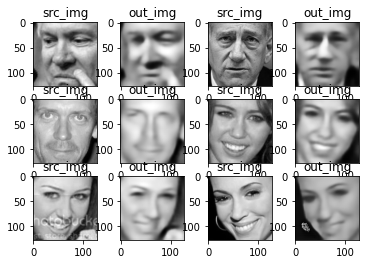

In [ ]:
net = AutoEncoder()
ckpt = osp.join(checkpoint, "net.pth") # 普通AE
# ckpt = osp.join(CHECKPOINT, "G.pth") # 增加GAN的AE
# ckpt = osp.join(CHECKPOINT, "G_fix.pth") # 圖型修復的AE
net.load_state_dict(torch.load(ckpt)) # 載入模型
net.eval()
for i in range(6):
    src, _ = val_data[i]
    img = transforms.ToPILImage()(src)
    print(i)
    plt.subplot(3, 4, (i + 1) * 2 - 1)
    plt.title("src_img")
    plt.imshow(img, cmap="gray")
    out = net(src.unsqueeze(0)).squeeze(0)
    out_img = transforms.ToPILImage()(out)
    plt.subplot(3, 4, (i + 1) * 2)
    plt.title("out_img")
    plt.imshow(out_img, cmap="gray")
    plt.savefig("auto_encoder_face.jpg")
plt.show()

可以看到，結果不是很清晰，這個結果，與AE選擇的損失有關:
1. L1損失和MSE損失的曲線比較平坦，損失下降速度慢
2. 在AE任務中，L1損失和MSE損失會考慮整體的誤差值，而對線條輪廓，缺乏敏感度
3. 在優化過程中，L1損失和MSE損失都會傾向於接近平均值，導致圖型變得模糊

為了解決這個問題，可以考慮引入一個能自主學習的損失函數。例如GAN。

## GAN與AE結合

將AE作為GAN的生成網絡，然後增加一個分類網絡，作為GAN的判別網絡，這裡選擇使用ResNet-18。

AE-GAN的損失函數，由三部分組成:
1. 判別器的分類損失
2. AE損失
3. 中間特徵圖的損失

$$J_G(x) = ||x - \hat x||^2 + \beta*\sum\limits_{i=1}^{n}||D_i(x) - D_i(\hat x)||^2$$
其中:
* x 是真圖片
* $\hat x$ 是生成的圖片
* $\beta$ 是調節係數
* $D_i$ 表示判別器中，第 i 層計算得到的特徵圖

將特徵圖損失加入生成器損失，能夠讓生成器，學習到除了像素值之外的資訊(如圖片的輪廓、紋理等)，從而得到優秀的生成結果。

In [ ]:
import torch


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
SIZE = 128
BATCH_SIZE = 16
# EPOCH_LR = [(30,0.01),(30,0.001)]
EPOCH_LR = [(30, 0.01), (30, 0.001), (50, 0.001)]
CHECKPOINT = "./"
DATA_FOLDER = "pubfig_faces_eval"

In [ ]:
from torch import nn, optim
# from auto_encoder import AutoEncoder
# from config import device, EPOCH_LR, CHECKPOINT

# from data import train_loader, val_loader
# from fix_data import train_loader, val_loader

from torchvision.models import resnet18
from tqdm import tqdm
import os
import torch
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# 計算特徵圖損失
def feature_map_loss(D, fake_img, img):
    fm_criteron = nn.MSELoss()
    # 初始化損失
    fm_loss = 0.0
    # ResNet-18前幾層得到的特徵圖
    f1 = D.maxpool(D.relu(D.bn1(D.conv1(img))))
    f1_fake = D.maxpool(D.relu(D.bn1(D.conv1(fake_img))))
    fm_loss += fm_criteron(f1_fake, f1)
    # ResNet-18 layer1前幾層得到的特徵圖
    f2 = D.layer1(f1)
    f2_fake = D.layer1(f1_fake)
    fm_loss += fm_criteron(f2_fake, f2)
    # ResNet-18 layer2前幾層得到的特徵圖
    f3 = D.layer2(f2)
    f3_fake = D.layer2(f2_fake)
    fm_loss += fm_criteron(f3_fake, f3)
    # ResNet-18 layer3前幾層得到的特徵圖
    f4 = D.layer3(f3)
    f4_fake = D.layer3(f3_fake)
    fm_loss += fm_criteron(f4_fake, f4)
    # ResNet-18 layer4前幾層得到的特徵圖
    f5 = D.layer4(f4)
    f5_fake = D.layer4(f4_fake)
    fm_loss += fm_criteron(f5_fake, f5)
    return fm_loss

In [ ]:
G = AutoEncoder().to(device) # 生成器
D = resnet18(num_classes=1) # 判別器
D.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # 黑白圖片一個通道
D = D.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 圖型壓縮
checkpoint_G = os.path.join(CHECKPOINT, "G.pth")
checkpoint_D = os.path.join(CHECKPOINT, "D.pth")
# 圖型修復
# checkpoint_G = os.path.join(CHECKPOINT, "G_fix.pth")
# checkpoint_D = os.path.join(CHECKPOINT, "D_fix.pth")

# 判斷模型檔案是否存在
# if os.path.exists(checkpoint_G):
#     G.load_state_dict(torch.load(checkpoint_G))
# if os.path.exists(checkpoint_G):
#     D.load_state_dict(torch.load(checkpoint_D))

In [ ]:
BCE_loss = nn.BCELoss() # 判別器的損失
MSE_loss = nn.MSELoss() # 特徵圖損失
writer = SummaryWriter("log")

for n, (num_epoch, lr) in enumerate(EPOCH_LR):
    G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(num_epoch):
        D.train()
        G.train()
        for i, (img_src, img_tgt) in tqdm(
            enumerate(train_loader), total=len(train_loader)
        ):
            # 訓練判別器
            D_optimizer.zero_grad()
            mini_batch = img_src.size()[0]
            # 建立標籤
            y_real = torch.ones(mini_batch)
            y_fake = torch.zeros(mini_batch)
            # 計算真圖片誤差
            img_src, img_tgt, y_real, y_fake = (
                img_src.to(device),
                img_tgt.to(device),
                y_real.to(device),
                y_fake.to(device),
            )
            D_result = torch.sigmoid(D(img_tgt)).squeeze()
            D_real_loss = BCE_loss(D_result, y_real)
            # 計算假圖片誤差
            img_fake = G(img_src)
            D_result = torch.sigmoid(D(img_fake)).squeeze()
            D_fake_loss = BCE_loss(D_result, y_fake)
            # 反向傳播
            D_train_loss = D_real_loss + D_fake_loss
            D_train_loss.backward()
            D_optimizer.step()

            # 訓練AutoEncoder
            G_optimizer.zero_grad()
            img_fake = G(img_src)
            AE_train_loss = MSE_loss(img_fake, img_tgt)
            # AE_train_loss.backward()
            # G_optimizer.step()

            # 訓練生成器
            # G_optimizer.zero_grad()
            img_fake = G(img_src)
            D_result = torch.sigmoid(D(img_fake)).squeeze()
            # G_train_loss = BCE_loss(D_result, y_real) + feature_map_loss(
            #     D, img_fake, img
            # )
            G_train_loss = AE_train_loss + feature_map_loss(
                D, img_fake, img_tgt
            )
            G_train_loss.backward()
            G_optimizer.step()

        print(
            "D train loss : {} , G train loss : {}, AE train Loss : {}".format(
                D_train_loss, G_train_loss, AE_train_loss
            )
        )
        # 損失加入TensorBoard
        writer.add_scalar(
            "D_train_loss",
            D_train_loss / len(train_loader),
            sum([e[0] for e in EPOCH_LR[:n]]) + epoch,
        )
        writer.add_scalar(
            "G_train_loss",
            G_train_loss / len(train_loader),
            sum([e[0] for e in EPOCH_LR[:n]]) + epoch,
        )
        writer.add_scalar(
            "AE_train_loss",
            AE_train_loss / len(train_loader),
            sum([e[0] for e in EPOCH_LR[:n]]) + epoch,
        )
        with torch.no_grad():
            D.eval()
            G.eval()
            for i, (img_src, img_tgt) in tqdm(
                enumerate(val_loader), total=len(val_loader)
            ):
                mini_batch = img_src.size()[0]
                # 真假標籤
                y_real = torch.ones(mini_batch)
                y_fake = torch.zeros(mini_batch)
                # 傳入GPU
                img_src, img_tgt, y_real, y_fake = (
                    img_src.to(device),
                    img_tgt.to(device),
                    y_real.to(device),
                    y_fake.to(device),
                )
                # 真圖片損失
                D_result = torch.sigmoid(D(img_tgt)).squeeze()
                D_real_loss = BCE_loss(D_result, y_real)

                # 生成假圖片
                # noise = torch.randn((mini_batch, noise_length)).view((-1, noise_length, 1, 1)).to(device)
                img_fake = G(img_src)
                # 假圖片損失
                D_result = torch.sigmoid(D(img_fake)).squeeze()
                D_fake_loss = BCE_loss(D_result, y_fake)

                D_val_loss = D_real_loss + D_fake_loss

                # 生成器損失
                AE_val_loss = MSE_loss(img_fake, img_tgt)

                # noise = torch.randn((mini_batch, noise_length)).view((-1, 100, 1, 1)).to(device)
                img_fake = G(img_src)
                D_result = torch.sigmoid(D(img_fake)).squeeze()
                G_val_loss = BCE_loss(D_result, y_real)

        print(
            "D val loss : {} , G val loss : {} , AE val loss : {} ".format(
                D_val_loss, G_val_loss, AE_val_loss
            )
        )
        # 損失加入TensorBoard
        writer.add_scalar(
            "D_val_loss",
            D_val_loss / len(val_loader),
            sum([e[0] for e in EPOCH_LR[:n]]) + epoch,
        )
        writer.add_scalar(
            "G_val_loss",
            G_val_loss / len(val_loader),
            sum([e[0] for e in EPOCH_LR[:n]]) + epoch,
        )
        writer.add_scalar(
            "AE_val_loss",
            AE_val_loss / len(val_loader),
            sum([e[0] for e in EPOCH_LR[:n]]) + epoch,
        )
        torch.save(G.state_dict(), checkpoint_G)
        torch.save(D.state_dict(), checkpoint_D)
writer.close()

100%|██████████| 102/102 [00:29<00:00,  3.43it/s]


D train loss : 0.011911498382687569 , G train loss : 7.853546142578125, AE train Loss : 0.07475874572992325


100%|██████████| 13/13 [00:01<00:00, 12.33it/s]


D val loss : 1.4794957637786865 , G val loss : 2.0132250785827637 , AE val loss : 0.5900495648384094 


100%|██████████| 102/102 [00:28<00:00,  3.64it/s]


D train loss : 0.24025481939315796 , G train loss : 5.9107232093811035, AE train Loss : 0.04034363850951195


100%|██████████| 13/13 [00:01<00:00, 12.59it/s]


D val loss : 1.7843430042266846 , G val loss : 1.0602082014083862 , AE val loss : 0.04242921248078346 


100%|██████████| 102/102 [00:28<00:00,  3.62it/s]


D train loss : 0.01287262886762619 , G train loss : 5.2012457847595215, AE train Loss : 0.04115181788802147


100%|██████████| 13/13 [00:01<00:00, 12.52it/s]


D val loss : 3.5756747722625732 , G val loss : 0.9611612558364868 , AE val loss : 0.03267259895801544 


100%|██████████| 102/102 [00:28<00:00,  3.60it/s]


D train loss : 0.028354529291391373 , G train loss : 3.020765781402588, AE train Loss : 0.04404987767338753


100%|██████████| 13/13 [00:01<00:00, 12.33it/s]


D val loss : 1.390272855758667 , G val loss : 0.48316511511802673 , AE val loss : 0.050227295607328415 


100%|██████████| 102/102 [00:28<00:00,  3.59it/s]


D train loss : 1.9932219982147217 , G train loss : 3.86281156539917, AE train Loss : 0.048196230083703995


100%|██████████| 13/13 [00:01<00:00, 12.56it/s]


D val loss : 1.7409368753433228 , G val loss : 0.32922062277793884 , AE val loss : 0.04159422963857651 


100%|██████████| 102/102 [00:28<00:00,  3.52it/s]


D train loss : 0.22083690762519836 , G train loss : 4.090747833251953, AE train Loss : 0.04386836290359497


100%|██████████| 13/13 [00:01<00:00, 12.52it/s]


D val loss : 1.6416058540344238 , G val loss : 0.2829259932041168 , AE val loss : 0.04145374149084091 


100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


D train loss : 0.06213853880763054 , G train loss : 4.307163715362549, AE train Loss : 0.058882974088191986


100%|██████████| 13/13 [00:01<00:00, 12.49it/s]


D val loss : 2.5763938426971436 , G val loss : 1.7386829853057861 , AE val loss : 0.089438296854496 


100%|██████████| 102/102 [00:28<00:00,  3.57it/s]


D train loss : 0.113286092877388 , G train loss : 3.350748300552368, AE train Loss : 0.04113985225558281


100%|██████████| 13/13 [00:01<00:00, 12.49it/s]


D val loss : 1.4405465126037598 , G val loss : 0.7123084664344788 , AE val loss : 0.037524085491895676 


100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


D train loss : 0.16337400674819946 , G train loss : 6.67964506149292, AE train Loss : 0.044839292764663696


100%|██████████| 13/13 [00:01<00:00, 12.78it/s]


D val loss : 1.4865589141845703 , G val loss : 0.7748293876647949 , AE val loss : 0.06493387371301651 


100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


D train loss : 0.019536925479769707 , G train loss : 6.031264305114746, AE train Loss : 0.033148039132356644


100%|██████████| 13/13 [00:01<00:00, 12.63it/s]


D val loss : 2.2865376472473145 , G val loss : 1.7162575721740723 , AE val loss : 0.04097919166088104 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.012122133746743202 , G train loss : 5.448075771331787, AE train Loss : 0.03181615471839905


100%|██████████| 13/13 [00:01<00:00, 12.41it/s]


D val loss : 1.20578932762146 , G val loss : 0.5863098502159119 , AE val loss : 0.02759699709713459 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 1.2665610313415527 , G train loss : 3.870415449142456, AE train Loss : 0.045660506933927536


100%|██████████| 13/13 [00:01<00:00, 12.74it/s]


D val loss : 3.0332117080688477 , G val loss : 3.7706260681152344 , AE val loss : 0.05757773667573929 


100%|██████████| 102/102 [00:28<00:00,  3.53it/s]


D train loss : 0.33502301573753357 , G train loss : 3.1302943229675293, AE train Loss : 0.03199351578950882


100%|██████████| 13/13 [00:01<00:00, 12.50it/s]


D val loss : 1.3803985118865967 , G val loss : 0.44502755999565125 , AE val loss : 0.03455230966210365 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.5643306970596313 , G train loss : 3.876216173171997, AE train Loss : 0.027709633111953735


100%|██████████| 13/13 [00:01<00:00, 12.40it/s]


D val loss : 2.180210590362549 , G val loss : 0.14016875624656677 , AE val loss : 0.0324816070497036 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.017238851636648178 , G train loss : 4.704233646392822, AE train Loss : 0.034203171730041504


100%|██████████| 13/13 [00:01<00:00, 12.66it/s]


D val loss : 1.925013780593872 , G val loss : 1.8226869106292725 , AE val loss : 0.03696427121758461 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.39353662729263306 , G train loss : 3.6778082847595215, AE train Loss : 0.03369582071900368


100%|██████████| 13/13 [00:01<00:00, 12.66it/s]


D val loss : 1.9823955297470093 , G val loss : 0.25459450483322144 , AE val loss : 0.03449570760130882 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.010923458263278008 , G train loss : 5.0540266036987305, AE train Loss : 0.041668910533189774


100%|██████████| 13/13 [00:01<00:00, 12.26it/s]


D val loss : 4.371362209320068 , G val loss : 2.311166763305664 , AE val loss : 0.047539982944726944 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.19003596901893616 , G train loss : 2.924239158630371, AE train Loss : 0.03893188014626503


100%|██████████| 13/13 [00:01<00:00, 12.86it/s]


D val loss : 1.2339946031570435 , G val loss : 1.092341661453247 , AE val loss : 0.03378908708691597 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.03201993927359581 , G train loss : 2.7479236125946045, AE train Loss : 0.030050363391637802


100%|██████████| 13/13 [00:01<00:00, 11.91it/s]


D val loss : 1.357295036315918 , G val loss : 1.6438077688217163 , AE val loss : 0.029313700273633003 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.06537649035453796 , G train loss : 2.715906858444214, AE train Loss : 0.029167555272579193


100%|██████████| 13/13 [00:01<00:00, 12.44it/s]


D val loss : 2.2034459114074707 , G val loss : 2.3166263103485107 , AE val loss : 0.02878008596599102 


100%|██████████| 102/102 [00:28<00:00,  3.52it/s]


D train loss : 0.0015714267501607537 , G train loss : 3.4167046546936035, AE train Loss : 0.03458276763558388


100%|██████████| 13/13 [00:01<00:00, 11.93it/s]


D val loss : 1.9320247173309326 , G val loss : 2.221367835998535 , AE val loss : 0.03376982733607292 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.01598096266388893 , G train loss : 2.8168582916259766, AE train Loss : 0.029142288491129875


100%|██████████| 13/13 [00:01<00:00, 11.89it/s]


D val loss : 1.5686850547790527 , G val loss : 1.1930077075958252 , AE val loss : 0.023695169016718864 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.09531795233488083 , G train loss : 2.37191104888916, AE train Loss : 0.028044430539011955


100%|██████████| 13/13 [00:01<00:00, 12.45it/s]


D val loss : 2.11367130279541 , G val loss : 2.2250475883483887 , AE val loss : 0.031975362449884415 


100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


D train loss : 1.8476312160491943 , G train loss : 2.729950428009033, AE train Loss : 0.03278697654604912


100%|██████████| 13/13 [00:01<00:00, 12.88it/s]


D val loss : 1.3568533658981323 , G val loss : 0.8105636239051819 , AE val loss : 0.02954515814781189 


100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


D train loss : 0.21668805181980133 , G train loss : 2.8562979698181152, AE train Loss : 0.03372882306575775


100%|██████████| 13/13 [00:01<00:00, 12.63it/s]


D val loss : 2.0671133995056152 , G val loss : 1.7709405422210693 , AE val loss : 0.03256790339946747 


100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


D train loss : 0.008320456370711327 , G train loss : 2.602792501449585, AE train Loss : 0.029623690992593765


100%|██████████| 13/13 [00:01<00:00, 12.70it/s]


D val loss : 2.648677110671997 , G val loss : 2.5044991970062256 , AE val loss : 0.02997669205069542 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 1.0613149404525757 , G train loss : 2.6197049617767334, AE train Loss : 0.020607614889740944


100%|██████████| 13/13 [00:01<00:00, 12.54it/s]


D val loss : 1.4872379302978516 , G val loss : 1.440826416015625 , AE val loss : 0.02273956686258316 


100%|██████████| 102/102 [00:28<00:00,  3.53it/s]


D train loss : 0.2604522407054901 , G train loss : 1.9188393354415894, AE train Loss : 0.02304462157189846


100%|██████████| 13/13 [00:01<00:00, 12.87it/s]


D val loss : 2.2319493293762207 , G val loss : 2.118203639984131 , AE val loss : 0.023930732160806656 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.09106921404600143 , G train loss : 2.1387393474578857, AE train Loss : 0.021661793813109398


100%|██████████| 13/13 [00:01<00:00, 12.83it/s]


D val loss : 1.6423871517181396 , G val loss : 1.3482422828674316 , AE val loss : 0.028660666197538376 


100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


D train loss : 0.619401752948761 , G train loss : 2.2845849990844727, AE train Loss : 0.026440070942044258


100%|██████████| 13/13 [00:01<00:00, 12.79it/s]


D val loss : 2.023090124130249 , G val loss : 1.8337546586990356 , AE val loss : 0.027111083269119263 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.042385272681713104 , G train loss : 1.9622511863708496, AE train Loss : 0.02233387529850006


100%|██████████| 13/13 [00:01<00:00, 12.87it/s]


D val loss : 1.8163024187088013 , G val loss : 1.7329998016357422 , AE val loss : 0.02120259404182434 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.010442491620779037 , G train loss : 2.1372454166412354, AE train Loss : 0.025577034801244736


100%|██████████| 13/13 [00:01<00:00, 12.94it/s]


D val loss : 1.5956475734710693 , G val loss : 1.265539526939392 , AE val loss : 0.024717314168810844 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.10620652139186859 , G train loss : 1.9997749328613281, AE train Loss : 0.021192995831370354


100%|██████████| 13/13 [00:01<00:00, 12.77it/s]


D val loss : 1.6580463647842407 , G val loss : 1.6319279670715332 , AE val loss : 0.023929057642817497 


100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


D train loss : 0.08661410212516785 , G train loss : 1.7668594121932983, AE train Loss : 0.026990680024027824


100%|██████████| 13/13 [00:01<00:00, 12.68it/s]


D val loss : 1.7440760135650635 , G val loss : 1.0383673906326294 , AE val loss : 0.024961180984973907 


100%|██████████| 102/102 [00:28<00:00,  3.53it/s]


D train loss : 0.02915184572339058 , G train loss : 1.807114839553833, AE train Loss : 0.02313358522951603


100%|██████████| 13/13 [00:01<00:00, 12.79it/s]


D val loss : 2.708723306655884 , G val loss : 2.901379108428955 , AE val loss : 0.018906686455011368 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.0382687970995903 , G train loss : 1.9903169870376587, AE train Loss : 0.022756122052669525


100%|██████████| 13/13 [00:01<00:00, 12.82it/s]


D val loss : 1.6352291107177734 , G val loss : 1.4756559133529663 , AE val loss : 0.021042071282863617 


100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


D train loss : 0.2432468682527542 , G train loss : 1.7665274143218994, AE train Loss : 0.022553691640496254


100%|██████████| 13/13 [00:01<00:00, 12.63it/s]


D val loss : 1.5394583940505981 , G val loss : 1.0355970859527588 , AE val loss : 0.025215957313776016 


100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


D train loss : 0.0886644572019577 , G train loss : 2.0728559494018555, AE train Loss : 0.024614131078124046


100%|██████████| 13/13 [00:01<00:00, 12.76it/s]


D val loss : 1.3506486415863037 , G val loss : 0.5606306195259094 , AE val loss : 0.022039154544472694 


100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


D train loss : 0.000693915702868253 , G train loss : 2.008082628250122, AE train Loss : 0.02170541323721409


100%|██████████| 13/13 [00:01<00:00, 12.59it/s]


D val loss : 1.6888091564178467 , G val loss : 1.58329176902771 , AE val loss : 0.018987935036420822 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.0037578269839286804 , G train loss : 2.0133423805236816, AE train Loss : 0.02193526178598404


100%|██████████| 13/13 [00:01<00:00, 12.18it/s]


D val loss : 1.9323471784591675 , G val loss : 1.7558833360671997 , AE val loss : 0.0242033451795578 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.00038387585664168 , G train loss : 1.9724228382110596, AE train Loss : 0.020864346995949745


100%|██████████| 13/13 [00:01<00:00, 12.10it/s]


D val loss : 3.219757556915283 , G val loss : 3.362999677658081 , AE val loss : 0.019858406856656075 


100%|██████████| 102/102 [00:29<00:00,  3.52it/s]


D train loss : 0.042141493409872055 , G train loss : 1.9422881603240967, AE train Loss : 0.024182751774787903


100%|██████████| 13/13 [00:01<00:00, 12.38it/s]


D val loss : 1.3880393505096436 , G val loss : 0.6691680550575256 , AE val loss : 0.025320157408714294 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 3.699627637863159 , G train loss : 2.046849012374878, AE train Loss : 0.029237976297736168


100%|██████████| 13/13 [00:01<00:00, 11.92it/s]


D val loss : 1.3897459506988525 , G val loss : 0.9181404113769531 , AE val loss : 0.021720632910728455 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.2645319998264313 , G train loss : 1.8857223987579346, AE train Loss : 0.025665288791060448


100%|██████████| 13/13 [00:01<00:00, 11.94it/s]


D val loss : 1.4486075639724731 , G val loss : 0.44506126642227173 , AE val loss : 0.0184674933552742 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.049130212515592575 , G train loss : 1.6581885814666748, AE train Loss : 0.021839981898665428


100%|██████████| 13/13 [00:01<00:00, 12.40it/s]


D val loss : 1.5797514915466309 , G val loss : 1.4660170078277588 , AE val loss : 0.018661245703697205 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.8716825246810913 , G train loss : 1.964389443397522, AE train Loss : 0.02275637909770012


100%|██████████| 13/13 [00:01<00:00, 12.37it/s]


D val loss : 1.5084782838821411 , G val loss : 1.0001072883605957 , AE val loss : 0.022932643070816994 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.16999061405658722 , G train loss : 1.916612148284912, AE train Loss : 0.020716389641165733


100%|██████████| 13/13 [00:01<00:00, 12.55it/s]


D val loss : 1.3664650917053223 , G val loss : 0.7832923531532288 , AE val loss : 0.021989353001117706 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.0022674049250781536 , G train loss : 1.9947739839553833, AE train Loss : 0.026255115866661072


100%|██████████| 13/13 [00:01<00:00, 12.72it/s]


D val loss : 2.4156999588012695 , G val loss : 2.534104347229004 , AE val loss : 0.021472711116075516 


100%|██████████| 102/102 [00:28<00:00,  3.53it/s]


D train loss : 0.03634936362504959 , G train loss : 1.772086262702942, AE train Loss : 0.03107074834406376


100%|██████████| 13/13 [00:01<00:00, 12.57it/s]


D val loss : 1.4389853477478027 , G val loss : 0.9778404235839844 , AE val loss : 0.019601956009864807 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.022017598152160645 , G train loss : 1.6888195276260376, AE train Loss : 0.02000345103442669


100%|██████████| 13/13 [00:01<00:00, 12.61it/s]


D val loss : 1.664552927017212 , G val loss : 1.5477852821350098 , AE val loss : 0.019577860832214355 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 1.9859367609024048 , G train loss : 1.7337533235549927, AE train Loss : 0.019934240728616714


100%|██████████| 13/13 [00:01<00:00, 12.19it/s]


D val loss : 2.4891364574432373 , G val loss : 2.396127223968506 , AE val loss : 0.018030747771263123 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.01813088171184063 , G train loss : 1.8585299253463745, AE train Loss : 0.024707458913326263


100%|██████████| 13/13 [00:01<00:00, 12.24it/s]


D val loss : 1.6034338474273682 , G val loss : 1.4035704135894775 , AE val loss : 0.019764559343457222 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.007034549489617348 , G train loss : 1.8346781730651855, AE train Loss : 0.02336381934583187


100%|██████████| 13/13 [00:01<00:00, 12.47it/s]


D val loss : 1.5528297424316406 , G val loss : 1.0571818351745605 , AE val loss : 0.01938067376613617 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.001385156181640923 , G train loss : 1.8077740669250488, AE train Loss : 0.0226281825453043


100%|██████████| 13/13 [00:01<00:00, 12.58it/s]


D val loss : 1.602105975151062 , G val loss : 1.3380975723266602 , AE val loss : 0.021886035799980164 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.04471559450030327 , G train loss : 1.5603787899017334, AE train Loss : 0.01809835620224476


100%|██████████| 13/13 [00:01<00:00, 12.11it/s]


D val loss : 1.4165958166122437 , G val loss : 0.9099703431129456 , AE val loss : 0.01654106192290783 


100%|██████████| 102/102 [00:28<00:00,  3.52it/s]


D train loss : 0.1587543785572052 , G train loss : 1.6679307222366333, AE train Loss : 0.021844636648893356


100%|██████████| 13/13 [00:01<00:00, 12.57it/s]


D val loss : 2.132751941680908 , G val loss : 2.1027655601501465 , AE val loss : 0.020479312166571617 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.037649400532245636 , G train loss : 1.5826797485351562, AE train Loss : 0.0185854509472847


100%|██████████| 13/13 [00:01<00:00, 12.46it/s]


D val loss : 1.6044901609420776 , G val loss : 1.3669542074203491 , AE val loss : 0.016733475029468536 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.003544083796441555 , G train loss : 1.6865506172180176, AE train Loss : 0.020500609651207924


100%|██████████| 13/13 [00:01<00:00, 12.47it/s]


D val loss : 2.2423386573791504 , G val loss : 2.377828598022461 , AE val loss : 0.016038550063967705 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.018598640337586403 , G train loss : 1.6162446737289429, AE train Loss : 0.017279313877224922


100%|██████████| 13/13 [00:01<00:00, 12.60it/s]


D val loss : 2.3555922508239746 , G val loss : 2.259065866470337 , AE val loss : 0.017355624586343765 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.09360193461179733 , G train loss : 1.5480371713638306, AE train Loss : 0.015337266959249973


100%|██████████| 13/13 [00:01<00:00, 12.62it/s]


D val loss : 1.2971055507659912 , G val loss : 0.6796760559082031 , AE val loss : 0.015026578679680824 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.013114726170897484 , G train loss : 1.572134256362915, AE train Loss : 0.018317587673664093


100%|██████████| 13/13 [00:01<00:00, 12.46it/s]


D val loss : 2.1284468173980713 , G val loss : 1.9421637058258057 , AE val loss : 0.016206232830882072 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.014756469987332821 , G train loss : 1.8258167505264282, AE train Loss : 0.0220032911747694


100%|██████████| 13/13 [00:01<00:00, 12.41it/s]


D val loss : 1.3470172882080078 , G val loss : 0.9235705733299255 , AE val loss : 0.015998683869838715 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.02971685118973255 , G train loss : 1.6540967226028442, AE train Loss : 0.019977645948529243


100%|██████████| 13/13 [00:01<00:00, 12.40it/s]


D val loss : 1.7153539657592773 , G val loss : 1.3750888109207153 , AE val loss : 0.01906442642211914 


100%|██████████| 102/102 [00:28<00:00,  3.52it/s]


D train loss : 0.06254024803638458 , G train loss : 1.434165358543396, AE train Loss : 0.017522454261779785


100%|██████████| 13/13 [00:01<00:00, 12.51it/s]


D val loss : 2.456880807876587 , G val loss : 2.5315937995910645 , AE val loss : 0.015636608004570007 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.0013645370490849018 , G train loss : 1.8065552711486816, AE train Loss : 0.020963124930858612


100%|██████████| 13/13 [00:01<00:00, 12.46it/s]


D val loss : 2.093014717102051 , G val loss : 1.9929027557373047 , AE val loss : 0.016890479251742363 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.004066091030836105 , G train loss : 1.6424217224121094, AE train Loss : 0.020406246185302734


100%|██████████| 13/13 [00:01<00:00, 12.61it/s]


D val loss : 1.5008693933486938 , G val loss : 0.9232797622680664 , AE val loss : 0.019166136160492897 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.047092363238334656 , G train loss : 1.3621455430984497, AE train Loss : 0.0160982608795166


100%|██████████| 13/13 [00:01<00:00, 12.66it/s]


D val loss : 2.322805881500244 , G val loss : 2.28759503364563 , AE val loss : 0.016083432361483574 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.006460828706622124 , G train loss : 1.7601380348205566, AE train Loss : 0.022495532408356667


100%|██████████| 13/13 [00:01<00:00, 12.50it/s]


D val loss : 1.837882399559021 , G val loss : 1.6010123491287231 , AE val loss : 0.017445145174860954 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.015191693790256977 , G train loss : 1.6446315050125122, AE train Loss : 0.018963109701871872


100%|██████████| 13/13 [00:01<00:00, 12.70it/s]


D val loss : 1.6626845598220825 , G val loss : 1.3805936574935913 , AE val loss : 0.016635939478874207 


100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


D train loss : 0.21089665591716766 , G train loss : 1.4453785419464111, AE train Loss : 0.015007280744612217


100%|██████████| 13/13 [00:01<00:00, 12.87it/s]


D val loss : 2.9786875247955322 , G val loss : 2.9561209678649902 , AE val loss : 0.01740933209657669 


100%|██████████| 102/102 [00:28<00:00,  3.53it/s]


D train loss : 0.03375336900353432 , G train loss : 1.5042554140090942, AE train Loss : 0.01959017477929592


100%|██████████| 13/13 [00:01<00:00, 12.98it/s]


D val loss : 1.895829200744629 , G val loss : 1.6886872053146362 , AE val loss : 0.016271447762846947 


100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


D train loss : 0.01872424967586994 , G train loss : 1.6553606986999512, AE train Loss : 0.017563596367836


100%|██████████| 13/13 [00:01<00:00, 12.79it/s]


D val loss : 1.4400160312652588 , G val loss : 1.0294798612594604 , AE val loss : 0.015304776839911938 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.07074541598558426 , G train loss : 1.5463963747024536, AE train Loss : 0.016512587666511536


100%|██████████| 13/13 [00:01<00:00, 12.78it/s]


D val loss : 1.5661298036575317 , G val loss : 1.2021913528442383 , AE val loss : 0.019018717110157013 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.008123473264276981 , G train loss : 1.6907362937927246, AE train Loss : 0.01900581456720829


100%|██████████| 13/13 [00:01<00:00, 12.69it/s]


D val loss : 1.6341216564178467 , G val loss : 1.3909215927124023 , AE val loss : 0.01705748215317726 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.16441144049167633 , G train loss : 1.539665699005127, AE train Loss : 0.018360041081905365


100%|██████████| 13/13 [00:01<00:00, 12.85it/s]


D val loss : 2.923551559448242 , G val loss : 2.8795742988586426 , AE val loss : 0.01889815367758274 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 1.0012038946151733 , G train loss : 1.5619759559631348, AE train Loss : 0.020669030025601387


100%|██████████| 13/13 [00:01<00:00, 12.51it/s]


D val loss : 1.5413241386413574 , G val loss : 1.1254980564117432 , AE val loss : 0.019061921164393425 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.051909271627664566 , G train loss : 1.5096491575241089, AE train Loss : 0.016767779365181923


100%|██████████| 13/13 [00:01<00:00, 12.59it/s]


D val loss : 1.5796184539794922 , G val loss : 1.1987971067428589 , AE val loss : 0.015073880553245544 


100%|██████████| 102/102 [00:28<00:00,  3.53it/s]


D train loss : 1.4918370246887207 , G train loss : 1.362277626991272, AE train Loss : 0.014163854531943798


100%|██████████| 13/13 [00:01<00:00, 12.69it/s]


D val loss : 2.3897969722747803 , G val loss : 2.305614948272705 , AE val loss : 0.013506682589650154 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.0016969391144812107 , G train loss : 1.383080005645752, AE train Loss : 0.014306369237601757


100%|██████████| 13/13 [00:01<00:00, 12.71it/s]


D val loss : 2.1206281185150146 , G val loss : 1.8525795936584473 , AE val loss : 0.01612778566777706 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.2453642189502716 , G train loss : 1.4426814317703247, AE train Loss : 0.014727571047842503


100%|██████████| 13/13 [00:01<00:00, 12.39it/s]


D val loss : 2.2696282863616943 , G val loss : 2.236968755722046 , AE val loss : 0.013164973817765713 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.05788137763738632 , G train loss : 1.525207757949829, AE train Loss : 0.021235594525933266


100%|██████████| 13/13 [00:01<00:00, 12.67it/s]


D val loss : 1.414520263671875 , G val loss : 0.8628175258636475 , AE val loss : 0.016557615250349045 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.008526678197085857 , G train loss : 1.3436833620071411, AE train Loss : 0.015468057245016098


100%|██████████| 13/13 [00:01<00:00, 12.52it/s]


D val loss : 2.3089985847473145 , G val loss : 2.1701083183288574 , AE val loss : 0.016638610512018204 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.007508392911404371 , G train loss : 1.5980298519134521, AE train Loss : 0.016450190916657448


100%|██████████| 13/13 [00:01<00:00, 12.53it/s]


D val loss : 1.537943959236145 , G val loss : 1.1393674612045288 , AE val loss : 0.015203151851892471 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.013431157916784286 , G train loss : 1.5636178255081177, AE train Loss : 0.01564309559762478


100%|██████████| 13/13 [00:01<00:00, 12.28it/s]


D val loss : 2.5435993671417236 , G val loss : 2.385655641555786 , AE val loss : 0.014628680422902107 


100%|██████████| 102/102 [00:28<00:00,  3.52it/s]


D train loss : 0.006101041566580534 , G train loss : 1.4767640829086304, AE train Loss : 0.0143122598528862


100%|██████████| 13/13 [00:01<00:00, 12.80it/s]


D val loss : 1.4801725149154663 , G val loss : 1.2213603258132935 , AE val loss : 0.014681319706141949 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.16394567489624023 , G train loss : 1.638994574546814, AE train Loss : 0.019497131928801537


100%|██████████| 13/13 [00:01<00:00, 12.78it/s]


D val loss : 1.5392686128616333 , G val loss : 0.9325171709060669 , AE val loss : 0.015217452310025692 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.03401339799165726 , G train loss : 1.4458160400390625, AE train Loss : 0.016251198947429657


100%|██████████| 13/13 [00:01<00:00, 12.62it/s]


D val loss : 1.366302728652954 , G val loss : 0.6792891025543213 , AE val loss : 0.015055444091558456 


100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


D train loss : 0.07453039288520813 , G train loss : 1.3976372480392456, AE train Loss : 0.01595771685242653


100%|██████████| 13/13 [00:01<00:00, 12.80it/s]


D val loss : 3.2075326442718506 , G val loss : 3.154386281967163 , AE val loss : 0.01588214933872223 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.0010472635040059686 , G train loss : 1.4574589729309082, AE train Loss : 0.0152571527287364


100%|██████████| 13/13 [00:01<00:00, 12.80it/s]


D val loss : 1.4286730289459229 , G val loss : 0.8825482130050659 , AE val loss : 0.01535793486982584 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.019717112183570862 , G train loss : 1.3421194553375244, AE train Loss : 0.015540791675448418


100%|██████████| 13/13 [00:01<00:00, 12.47it/s]


D val loss : 2.481095790863037 , G val loss : 2.4140334129333496 , AE val loss : 0.018285557627677917 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 1.3850820064544678 , G train loss : 1.5083889961242676, AE train Loss : 0.017318014055490494


100%|██████████| 13/13 [00:01<00:00, 12.69it/s]


D val loss : 1.76682448387146 , G val loss : 1.5975000858306885 , AE val loss : 0.016818715259432793 


100%|██████████| 102/102 [00:28<00:00,  3.52it/s]


D train loss : 0.04009682685136795 , G train loss : 1.4864847660064697, AE train Loss : 0.015407158993184566


100%|██████████| 13/13 [00:01<00:00, 12.57it/s]


D val loss : 1.4022680521011353 , G val loss : 0.9112438559532166 , AE val loss : 0.016846254467964172 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.2686446011066437 , G train loss : 1.6678588390350342, AE train Loss : 0.015729371458292007


100%|██████████| 13/13 [00:01<00:00, 12.53it/s]


D val loss : 1.5129287242889404 , G val loss : 0.5505797266960144 , AE val loss : 0.013862384483218193 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.022355467081069946 , G train loss : 1.4099012613296509, AE train Loss : 0.015425167977809906


100%|██████████| 13/13 [00:01<00:00, 12.53it/s]


D val loss : 1.5106264352798462 , G val loss : 1.1758273839950562 , AE val loss : 0.01497599110007286 


100%|██████████| 102/102 [00:28<00:00,  3.53it/s]


D train loss : 0.20877256989479065 , G train loss : 1.6241154670715332, AE train Loss : 0.017376545816659927


100%|██████████| 13/13 [00:01<00:00, 12.43it/s]


D val loss : 1.4371280670166016 , G val loss : 0.6897690892219543 , AE val loss : 0.015133102424442768 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.18619905412197113 , G train loss : 1.3871608972549438, AE train Loss : 0.017341572791337967


100%|██████████| 13/13 [00:01<00:00, 12.61it/s]


D val loss : 1.620987892150879 , G val loss : 1.340174674987793 , AE val loss : 0.014667604118585587 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.07902301847934723 , G train loss : 1.5183502435684204, AE train Loss : 0.013900034129619598


100%|██████████| 13/13 [00:01<00:00, 12.80it/s]


D val loss : 1.6956884860992432 , G val loss : 1.3905619382858276 , AE val loss : 0.016176316887140274 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.02162260375916958 , G train loss : 1.3280353546142578, AE train Loss : 0.01932353712618351


100%|██████████| 13/13 [00:01<00:00, 12.74it/s]


D val loss : 1.8443515300750732 , G val loss : 1.607110619544983 , AE val loss : 0.014546562917530537 


100%|██████████| 102/102 [00:28<00:00,  3.53it/s]


D train loss : 4.639808177947998 , G train loss : 1.5122547149658203, AE train Loss : 0.014422326348721981


100%|██████████| 13/13 [00:01<00:00, 12.82it/s]


D val loss : 2.1335883140563965 , G val loss : 2.0112881660461426 , AE val loss : 0.01292614359408617 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 1.0299193859100342 , G train loss : 1.5639073848724365, AE train Loss : 0.01460095215588808


100%|██████████| 13/13 [00:01<00:00, 12.49it/s]


D val loss : 1.4663547277450562 , G val loss : 0.5833678245544434 , AE val loss : 0.015831638127565384 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.6874144673347473 , G train loss : 1.395147442817688, AE train Loss : 0.01664448156952858


100%|██████████| 13/13 [00:01<00:00, 12.70it/s]


D val loss : 1.4389936923980713 , G val loss : 0.9332239627838135 , AE val loss : 0.013621325604617596 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.3394111394882202 , G train loss : 1.449257493019104, AE train Loss : 0.014735212549567223


100%|██████████| 13/13 [00:01<00:00, 12.69it/s]


D val loss : 2.1151487827301025 , G val loss : 1.927804946899414 , AE val loss : 0.01398396771401167 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.01365921925753355 , G train loss : 1.3179153203964233, AE train Loss : 0.013639609329402447


100%|██████████| 13/13 [00:01<00:00, 12.65it/s]


D val loss : 1.9806582927703857 , G val loss : 1.981699824333191 , AE val loss : 0.01441250927746296 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.018908746540546417 , G train loss : 1.2391777038574219, AE train Loss : 0.01862381584942341


100%|██████████| 13/13 [00:01<00:00, 12.52it/s]


D val loss : 2.30354905128479 , G val loss : 2.2587180137634277 , AE val loss : 0.014028606005012989 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 5.016539573669434 , G train loss : 1.6934164762496948, AE train Loss : 0.01582784578204155


100%|██████████| 13/13 [00:01<00:00, 12.72it/s]


D val loss : 1.433469295501709 , G val loss : 0.5308722853660583 , AE val loss : 0.013243677094578743 


100%|██████████| 102/102 [00:28<00:00,  3.53it/s]


D train loss : 0.0023642091546207666 , G train loss : 1.5015113353729248, AE train Loss : 0.014495966956019402


100%|██████████| 13/13 [00:01<00:00, 12.61it/s]


D val loss : 1.9920786619186401 , G val loss : 1.687906265258789 , AE val loss : 0.0159608107060194 


100%|██████████| 102/102 [00:28<00:00,  3.55it/s]


D train loss : 0.43096446990966797 , G train loss : 1.6182082891464233, AE train Loss : 0.01534003484994173


100%|██████████| 13/13 [00:01<00:00, 12.48it/s]


D val loss : 1.5558907985687256 , G val loss : 0.3798712193965912 , AE val loss : 0.012064705602824688 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.09349468350410461 , G train loss : 1.4062072038650513, AE train Loss : 0.0137266144156456


100%|██████████| 13/13 [00:01<00:00, 12.67it/s]


D val loss : 1.3507884740829468 , G val loss : 0.5740194916725159 , AE val loss : 0.015771469101309776 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.5242128968238831 , G train loss : 1.4078514575958252, AE train Loss : 0.013674067333340645


100%|██████████| 13/13 [00:01<00:00, 12.72it/s]


D val loss : 2.652301549911499 , G val loss : 2.506143808364868 , AE val loss : 0.01634732075035572 


100%|██████████| 102/102 [00:28<00:00,  3.54it/s]


D train loss : 0.02173556573688984 , G train loss : 1.3545767068862915, AE train Loss : 0.017629319801926613


100%|██████████| 13/13 [00:01<00:00, 12.20it/s]


D val loss : 3.857635498046875 , G val loss : 3.8880221843719482 , AE val loss : 0.01265569869428873 


在GAN的訓練過程中，D和G的損失，都可能會有很大的波動，何時停止訓練，還是要根據圖型生成的結果，來進行判斷。

In [ ]:
# from auto_encoder import AutoEncoder
# from config import CHECKPOINT
# from fix_data import val_data, train_data
import torch
import os.path as osp
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

0
1
2
3
4
5


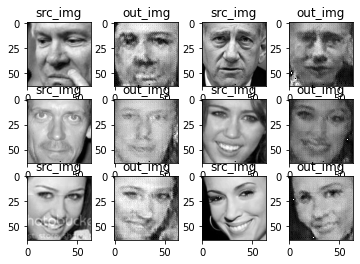

In [ ]:
# 效果展示
net = AutoEncoder()
# ckpt = osp.join(CHECKPOINT, "net.pth") # 普通AE
ckpt = osp.join(CHECKPOINT, "G.pth") # 增加GAN的AE
# ckpt = osp.join(CHECKPOINT, "G_fix.pth") # 圖型修復的AE
net.load_state_dict(torch.load(ckpt)) # 載入模型
net.eval()
for i in range(6):
    src, _ = val_data[i]
    img = transforms.ToPILImage()(src)
    print(i)
    plt.subplot(3, 4, (i + 1) * 2 - 1)
    plt.title("src_img")
    plt.imshow(img, cmap="gray")
    out = net(src.unsqueeze(0)).squeeze(0)
    out_img = transforms.ToPILImage()(out)
    plt.subplot(3, 4, (i + 1) * 2)
    plt.title("out_img")
    plt.imshow(out_img, cmap="gray")
    plt.savefig("auto_encoder_gan_face.jpg")
plt.show()

## 圖型修復

AE-GAN模型也可以完成一些影像處理類別的任務。同樣地，超解析度重建模型，也可以用於圖型壓縮。

下面使用AE-GAN進行圖型修復，只需要修改一下Dataset即可。

我們生成一個隨機的馬賽克，覆蓋在人臉上，然後將覆蓋之後的圖片與原圖片，組成圖片對，分別做為img_src和img_tgt，輸入到AE-GAN，進行訓練。

In [ ]:
import torch


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
SIZE = 128
BATCH_SIZE = 16
# EPOCH_LR = [(30,0.01),(30,0.001)]
EPOCH_LR = [(30, 0.01), (30, 0.001), (50, 0.001)]
CHECKPOINT = "./"
DATA_FOLDER = "pubfig_faces_eval"

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
# from config import DATA_FOLDER, BATCH_SIZE, SIZE
from glob import glob
import os.path as osp
from PIL import Image
from torchvision import transforms
import random
import torch

In [ ]:
class FixData(Dataset):
    def __init__(self, folder=DATA_FOLDER, subset="train", transform=None):
        img_paths = glob(osp.join(DATA_FOLDER, "*/*.jpg"))
        # 劃分訓練集和測試集
        train_paths, test_paths = train_test_split(
            img_paths, test_size=0.2, random_state=10
        )
        # 訓練集
        if subset == "train":
            self.img_paths = train_paths
        # 測試集
        else:
            self.img_paths = test_paths
        # 資料增強
        if transform is None:
            self.transform = transforms.Compose(
                [transforms.Resize((SIZE, SIZE)), transforms.ToTensor()]
            )
        else:
            self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.img_paths[index]).convert("L")
        img = self.transform(img)
        # 隨機選擇頂點
        w = int(SIZE / 3)
        xmin, ymin = (
            int(random.random() * (SIZE - w)),
            int(random.random() * (SIZE - w)),
        )
        img_src = img.clone()
        # 增加馬賽克
        img_src[:, ymin : ymin + w, xmin : xmin + w] = torch.rand((1, w, w))
        return img_src, img

    def __len__(self):
        return len(self.img_paths)

In [ ]:
# 資料增強
transform = transforms.Compose(
    [
        transforms.RandomRotation(15),
        transforms.Resize((SIZE, SIZE)),
        transforms.ToTensor(),
    ]
)

# 資料載入
train_data = FixData(subset="train", transform=transform)
val_data = FixData(subset="test")
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE * 2, shuffle=True)

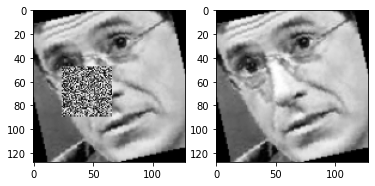

In [ ]:
if __name__ == "__main__":
    img_src, img_tgt = train_data[0]
    topil = transforms.ToPILImage()
    img_src = topil(img_src)
    img_tgt = topil(img_tgt)
    import matplotlib.pyplot as plt

    plt.subplot(121)
    plt.imshow(img_src, cmap="gray")
    plt.subplot(122)
    plt.imshow(img_tgt, cmap="gray")
    plt.show()

圖片修復的任務，就是要將被遮擋的區域，還原出來。

在對圖片進行了遮蓋之後，模型的訓練難度會變大。

In [ ]:
G = AutoEncoder().to(device) # 生成器
D = resnet18(num_classes=1) # 判別器
D.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # 黑白圖片一個通道
D = D.to(device)

In [ ]:
# 圖型壓縮
# checkpoint_G = os.path.join(CHECKPOINT, "G.pth")
# checkpoint_D = os.path.join(CHECKPOINT, "D.pth")
# 圖型修復
checkpoint_G = os.path.join(CHECKPOINT, "G_fix.pth")
checkpoint_D = os.path.join(CHECKPOINT, "D_fix.pth")

# 判斷模型檔案是否存在
if os.path.exists(checkpoint_G):
    G.load_state_dict(torch.load(checkpoint_G))
if os.path.exists(checkpoint_G):
    D.load_state_dict(torch.load(checkpoint_D))

In [ ]:
BCE_loss = nn.BCELoss() # 判別器的損失
MSE_loss = nn.MSELoss() # 特徵圖損失
writer = SummaryWriter("log")

for n, (num_epoch, lr) in enumerate(EPOCH_LR):
    G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(num_epoch):
        D.train()
        G.train()
        for i, (img_src, img_tgt) in tqdm(
            enumerate(train_loader), total=len(train_loader)
        ):
            # 訓練判別器
            D_optimizer.zero_grad()
            mini_batch = img_src.size()[0]
            # 建立標籤
            y_real = torch.ones(mini_batch)
            y_fake = torch.zeros(mini_batch)
            # 計算真圖片誤差
            img_src, img_tgt, y_real, y_fake = (
                img_src.to(device),
                img_tgt.to(device),
                y_real.to(device),
                y_fake.to(device),
            )
            D_result = torch.sigmoid(D(img_tgt)).squeeze()
            D_real_loss = BCE_loss(D_result, y_real)
            # 計算假圖片誤差
            img_fake = G(img_src)
            D_result = torch.sigmoid(D(img_fake)).squeeze()
            D_fake_loss = BCE_loss(D_result, y_fake)
            # 反向傳播
            D_train_loss = D_real_loss + D_fake_loss
            D_train_loss.backward()
            D_optimizer.step()

            # 訓練AutoEncoder
            G_optimizer.zero_grad()
            img_fake = G(img_src)
            AE_train_loss = MSE_loss(img_fake, img_tgt)
            # AE_train_loss.backward()
            # G_optimizer.step()

            # 訓練生成器
            # G_optimizer.zero_grad()
            img_fake = G(img_src)
            D_result = torch.sigmoid(D(img_fake)).squeeze()
            # G_train_loss = BCE_loss(D_result, y_real) + feature_map_loss(
            #     D, img_fake, img
            # )
            G_train_loss = AE_train_loss + feature_map_loss(
                D, img_fake, img_tgt
            )
            G_train_loss.backward()
            G_optimizer.step()

        print(
            "D train loss : {} , G train loss : {}, AE train Loss : {}".format(
                D_train_loss, G_train_loss, AE_train_loss
            )
        )
        # 損失加入TensorBoard
        writer.add_scalar(
            "D_train_loss",
            D_train_loss / len(train_loader),
            sum([e[0] for e in EPOCH_LR[:n]]) + epoch,
        )
        writer.add_scalar(
            "G_train_loss",
            G_train_loss / len(train_loader),
            sum([e[0] for e in EPOCH_LR[:n]]) + epoch,
        )
        writer.add_scalar(
            "AE_train_loss",
            AE_train_loss / len(train_loader),
            sum([e[0] for e in EPOCH_LR[:n]]) + epoch,
        )
        with torch.no_grad():
            D.eval()
            G.eval()
            for i, (img_src, img_tgt) in tqdm(
                enumerate(val_loader), total=len(val_loader)
            ):
                mini_batch = img_src.size()[0]
                # 真假標籤
                y_real = torch.ones(mini_batch)
                y_fake = torch.zeros(mini_batch)
                # 傳入GPU
                img_src, img_tgt, y_real, y_fake = (
                    img_src.to(device),
                    img_tgt.to(device),
                    y_real.to(device),
                    y_fake.to(device),
                )
                # 真圖片損失
                D_result = torch.sigmoid(D(img_tgt)).squeeze()
                D_real_loss = BCE_loss(D_result, y_real)

                # 生成假圖片
                # noise = torch.randn((mini_batch, noise_length)).view((-1, noise_length, 1, 1)).to(device)
                img_fake = G(img_src)
                # 假圖片損失
                D_result = torch.sigmoid(D(img_fake)).squeeze()
                D_fake_loss = BCE_loss(D_result, y_fake)

                D_val_loss = D_real_loss + D_fake_loss

                # 生成器損失
                AE_val_loss = MSE_loss(img_fake, img_tgt)

                # noise = torch.randn((mini_batch, noise_length)).view((-1, 100, 1, 1)).to(device)
                img_fake = G(img_src)
                D_result = torch.sigmoid(D(img_fake)).squeeze()
                G_val_loss = BCE_loss(D_result, y_real)

        print(
            "D val loss : {} , G val loss : {} , AE val loss : {} ".format(
                D_val_loss, G_val_loss, AE_val_loss
            )
        )
        # 損失加入TensorBoard
        writer.add_scalar(
            "D_val_loss",
            D_val_loss / len(val_loader),
            sum([e[0] for e in EPOCH_LR[:n]]) + epoch,
        )
        writer.add_scalar(
            "G_val_loss",
            G_val_loss / len(val_loader),
            sum([e[0] for e in EPOCH_LR[:n]]) + epoch,
        )
        writer.add_scalar(
            "AE_val_loss",
            AE_val_loss / len(val_loader),
            sum([e[0] for e in EPOCH_LR[:n]]) + epoch,
        )
        torch.save(G.state_dict(), checkpoint_G)
        torch.save(D.state_dict(), checkpoint_D)
writer.close()

100%|██████████| 204/204 [01:19<00:00,  2.56it/s]


D train loss : 0.9239954948425293 , G train loss : 5.260097980499268, AE train Loss : 0.05111377686262131


100%|██████████| 26/26 [00:03<00:00,  7.63it/s]


D val loss : 1.3877378702163696 , G val loss : 1.4535259008407593 , AE val loss : 0.04875549301505089 


100%|██████████| 204/204 [01:20<00:00,  2.53it/s]


D train loss : 0.04086216166615486 , G train loss : 4.014886856079102, AE train Loss : 0.032714881002902985


100%|██████████| 26/26 [00:03<00:00,  7.48it/s]


D val loss : 2.3174006938934326 , G val loss : 1.857668399810791 , AE val loss : 0.02988881804049015 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.4356113374233246 , G train loss : 3.6128504276275635, AE train Loss : 0.036766283214092255


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 1.5145394802093506 , G val loss : 1.188346266746521 , AE val loss : 0.032580457627773285 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.002802456496283412 , G train loss : 3.5697081089019775, AE train Loss : 0.04039991647005081


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 1.3386917114257812 , G val loss : 1.644355297088623 , AE val loss : 0.027650345116853714 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.003295909846201539 , G train loss : 2.6219489574432373, AE train Loss : 0.02621687576174736


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 1.8693044185638428 , G val loss : 2.4635887145996094 , AE val loss : 0.022712048143148422 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 1.6746374368667603 , G train loss : 2.788506031036377, AE train Loss : 0.020566163584589958


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 1.60426926612854 , G val loss : 0.741285502910614 , AE val loss : 0.024577772244811058 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.01793893612921238 , G train loss : 3.0491652488708496, AE train Loss : 0.03000260889530182


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 1.322210669517517 , G val loss : 0.43928566575050354 , AE val loss : 0.030155863612890244 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.014756954275071621 , G train loss : 2.044665575027466, AE train Loss : 0.01662927120923996


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 2.14924693107605 , G val loss : 2.438027858734131 , AE val loss : 0.02526715211570263 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.10353599488735199 , G train loss : 2.3681955337524414, AE train Loss : 0.017078377306461334


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.2433313131332397 , G val loss : 2.070261001586914 , AE val loss : 0.021359657868742943 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.05431261658668518 , G train loss : 2.241957426071167, AE train Loss : 0.016423476859927177


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 2.37400221824646 , G val loss : 3.484172821044922 , AE val loss : 0.018632808700203896 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.005567068234086037 , G train loss : 2.937225341796875, AE train Loss : 0.0192167516797781


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.432280421257019 , G val loss : 1.9957115650177002 , AE val loss : 0.0419953316450119 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.6600044369697571 , G train loss : 2.697037935256958, AE train Loss : 0.014721540734171867


100%|██████████| 26/26 [00:03<00:00,  7.45it/s]


D val loss : 1.6834356784820557 , G val loss : 1.7747822999954224 , AE val loss : 0.017728041857481003 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.032325807958841324 , G train loss : 2.2232236862182617, AE train Loss : 0.015941094607114792


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 2.256152629852295 , G val loss : 2.5307204723358154 , AE val loss : 0.013213028199970722 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.002293032594025135 , G train loss : 2.601395606994629, AE train Loss : 0.015886342152953148


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 1.5626329183578491 , G val loss : 1.315662145614624 , AE val loss : 0.020755773410201073 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 1.3034380674362183 , G train loss : 3.206313133239746, AE train Loss : 0.014766216278076172


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 1.9302467107772827 , G val loss : 2.3537514209747314 , AE val loss : 0.020105529576539993 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.06171786040067673 , G train loss : 2.4920685291290283, AE train Loss : 0.01664971373975277


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 1.105992078781128 , G val loss : 1.2972019910812378 , AE val loss : 0.012492782436311245 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.022578775882720947 , G train loss : 2.7466020584106445, AE train Loss : 0.013675104826688766


100%|██████████| 26/26 [00:03<00:00,  7.36it/s]


D val loss : 1.343247652053833 , G val loss : 0.554570198059082 , AE val loss : 0.01666155457496643 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.008593812584877014 , G train loss : 2.370392322540283, AE train Loss : 0.01590397022664547


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 1.4727810621261597 , G val loss : 1.8709644079208374 , AE val loss : 0.014311118051409721 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0024096148554235697 , G train loss : 2.4795901775360107, AE train Loss : 0.020737847313284874


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.611769199371338 , G val loss : 1.547653317451477 , AE val loss : 0.012158798985183239 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.04255988821387291 , G train loss : 2.1588938236236572, AE train Loss : 0.014386266469955444


100%|██████████| 26/26 [00:03<00:00,  7.45it/s]


D val loss : 1.710456371307373 , G val loss : 1.6385600566864014 , AE val loss : 0.015926402062177658 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.035313930362463 , G train loss : 2.4273881912231445, AE train Loss : 0.014335795305669308


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.5155528783798218 , G val loss : 1.2396464347839355 , AE val loss : 0.013939143158495426 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.4614323675632477 , G train loss : 2.6757423877716064, AE train Loss : 0.010855077765882015


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 0.8268952369689941 , G val loss : 0.991016685962677 , AE val loss : 0.020956184715032578 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.014636934734880924 , G train loss : 2.890913486480713, AE train Loss : 0.013911409303545952


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.1341283321380615 , G val loss : 0.9448087811470032 , AE val loss : 0.015721458941698074 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.018351184204220772 , G train loss : 2.682321786880493, AE train Loss : 0.014551952481269836


100%|██████████| 26/26 [00:03<00:00,  7.38it/s]


D val loss : 1.6676673889160156 , G val loss : 0.9702597260475159 , AE val loss : 0.013291927985846996 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.0916309654712677 , G train loss : 2.550791025161743, AE train Loss : 0.020609207451343536


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 1.4600776433944702 , G val loss : 1.1091115474700928 , AE val loss : 0.016148846596479416 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.050526127219200134 , G train loss : 2.6634230613708496, AE train Loss : 0.012455756776034832


100%|██████████| 26/26 [00:03<00:00,  7.45it/s]


D val loss : 1.1954184770584106 , G val loss : 1.0600773096084595 , AE val loss : 0.010376684367656708 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.04944285750389099 , G train loss : 2.2264716625213623, AE train Loss : 0.011874666437506676


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 1.7918705940246582 , G val loss : 1.5878225564956665 , AE val loss : 0.01390715129673481 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.028392447158694267 , G train loss : 2.2414257526397705, AE train Loss : 0.014606843702495098


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 1.5022534132003784 , G val loss : 1.226812720298767 , AE val loss : 0.010019341483712196 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.1126193255186081 , G train loss : 2.330792188644409, AE train Loss : 0.014065248891711235


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 1.432254433631897 , G val loss : 1.4634863138198853 , AE val loss : 0.014594976790249348 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.05477549880743027 , G train loss : 2.632371664047241, AE train Loss : 0.012769866734743118


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.3425872325897217 , G val loss : 0.6277084350585938 , AE val loss : 0.014847594313323498 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 2.35617733001709 , G train loss : 2.387423038482666, AE train Loss : 0.012620151042938232


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 1.0601059198379517 , G val loss : 0.8145937323570251 , AE val loss : 0.010544276796281338 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.02130349539220333 , G train loss : 2.22027850151062, AE train Loss : 0.010977808386087418


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 2.134370803833008 , G val loss : 2.005488872528076 , AE val loss : 0.008084656670689583 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.012433335185050964 , G train loss : 2.543728828430176, AE train Loss : 0.013308725319802761


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.8916208744049072 , G val loss : 0.236597940325737 , AE val loss : 0.009936874732375145 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0021726409904658794 , G train loss : 2.1531922817230225, AE train Loss : 0.008889473043382168


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 2.311464548110962 , G val loss : 3.192650556564331 , AE val loss : 0.007884494960308075 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.0018417384708300233 , G train loss : 2.354393243789673, AE train Loss : 0.008422084152698517


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 1.5864109992980957 , G val loss : 1.7833722829818726 , AE val loss : 0.00937968771904707 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.005875485483556986 , G train loss : 1.9703255891799927, AE train Loss : 0.009346583858132362


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 3.3008596897125244 , G val loss : 3.4868640899658203 , AE val loss : 0.009226871654391289 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0029561680275946856 , G train loss : 2.245363712310791, AE train Loss : 0.007654204964637756


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 2.7133498191833496 , G val loss : 3.038769006729126 , AE val loss : 0.007807606365531683 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 9.853210212895647e-05 , G train loss : 2.540809392929077, AE train Loss : 0.009905735030770302


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.5117735862731934 , G val loss : 1.2322349548339844 , AE val loss : 0.008171824738383293 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0026670158840715885 , G train loss : 2.1963651180267334, AE train Loss : 0.013418201357126236


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 2.489715576171875 , G val loss : 2.9509871006011963 , AE val loss : 0.008392943069338799 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 9.019431308843195e-05 , G train loss : 2.379875421524048, AE train Loss : 0.009672228246927261


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 2.0960934162139893 , G val loss : 2.666295289993286 , AE val loss : 0.00783846341073513 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0004988500149920583 , G train loss : 2.369048595428467, AE train Loss : 0.008658082224428654


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 2.0683417320251465 , G val loss : 3.002488851547241 , AE val loss : 0.007142521906644106 


100%|██████████| 204/204 [01:21<00:00,  2.49it/s]


D train loss : 0.4399712383747101 , G train loss : 2.404008388519287, AE train Loss : 0.015399533323943615


100%|██████████| 26/26 [00:03<00:00,  7.46it/s]


D val loss : 2.5687239170074463 , G val loss : 3.122469663619995 , AE val loss : 0.010552153922617435 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.04245610535144806 , G train loss : 2.3808212280273438, AE train Loss : 0.010690754279494286


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 1.127590298652649 , G val loss : 1.5659888982772827 , AE val loss : 0.007395390886813402 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.003142216010019183 , G train loss : 2.1890664100646973, AE train Loss : 0.008658266626298428


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.5688029527664185 , G val loss : 0.7039010524749756 , AE val loss : 0.005864695180207491 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.002016648883000016 , G train loss : 2.3297762870788574, AE train Loss : 0.011655792593955994


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 3.727224111557007 , G val loss : 3.7953999042510986 , AE val loss : 0.010500581935048103 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.0028247965965420008 , G train loss : 2.687514305114746, AE train Loss : 0.014640336856245995


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 1.6786174774169922 , G val loss : 1.4804584980010986 , AE val loss : 0.008401758037507534 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.07883197069168091 , G train loss : 2.2655582427978516, AE train Loss : 0.010112965479493141


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 2.1042397022247314 , G val loss : 1.7076290845870972 , AE val loss : 0.006883035413920879 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0403156578540802 , G train loss : 2.6594810485839844, AE train Loss : 0.010791752487421036


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 1.3185458183288574 , G val loss : 0.7002136707305908 , AE val loss : 0.009893405251204967 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.00022076518507674336 , G train loss : 2.8015332221984863, AE train Loss : 0.012363860383629799


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 2.0835659503936768 , G val loss : 2.1417157649993896 , AE val loss : 0.007641520816832781 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.005033903289586306 , G train loss : 2.1777637004852295, AE train Loss : 0.011773021891713142


100%|██████████| 26/26 [00:03<00:00,  7.48it/s]


D val loss : 2.5239875316619873 , G val loss : 2.6367712020874023 , AE val loss : 0.007448755204677582 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.01883111521601677 , G train loss : 2.5471596717834473, AE train Loss : 0.008030070923268795


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.676375389099121 , G val loss : 0.28667840361595154 , AE val loss : 0.008107991889119148 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0143838906660676 , G train loss : 2.3617501258850098, AE train Loss : 0.013936555944383144


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 1.561431646347046 , G val loss : 0.41501230001449585 , AE val loss : 0.00752134108915925 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.30933907628059387 , G train loss : 2.206996440887451, AE train Loss : 0.010933909565210342


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.3642866611480713 , G val loss : 1.160189151763916 , AE val loss : 0.007856909185647964 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.6985476016998291 , G train loss : 2.1741743087768555, AE train Loss : 0.014776783995330334


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.7047984600067139 , G val loss : 1.2845710515975952 , AE val loss : 0.008781439624726772 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.03978123515844345 , G train loss : 2.2221131324768066, AE train Loss : 0.012673338875174522


100%|██████████| 26/26 [00:03<00:00,  7.45it/s]


D val loss : 1.6221482753753662 , G val loss : 0.4036218225955963 , AE val loss : 0.008489110507071018 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.005907982587814331 , G train loss : 2.09692120552063, AE train Loss : 0.0072219036519527435


100%|██████████| 26/26 [00:03<00:00,  7.38it/s]


D val loss : 2.2225828170776367 , G val loss : 2.161876678466797 , AE val loss : 0.00655887508764863 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.5087783932685852 , G train loss : 2.1519112586975098, AE train Loss : 0.01466008648276329


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 3.3152215480804443 , G val loss : 3.673283338546753 , AE val loss : 0.007165847811847925 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.192002534866333 , G train loss : 1.945803165435791, AE train Loss : 0.009168623015284538


100%|██████████| 26/26 [00:03<00:00,  7.38it/s]


D val loss : 2.7066385746002197 , G val loss : 3.1213133335113525 , AE val loss : 0.007382356561720371 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.011073661036789417 , G train loss : 2.2009847164154053, AE train Loss : 0.011448904871940613


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 2.3781039714813232 , G val loss : 2.5725574493408203 , AE val loss : 0.006456664763391018 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.04979098215699196 , G train loss : 2.1361448764801025, AE train Loss : 0.01263644453138113


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 2.357912540435791 , G val loss : 2.4137532711029053 , AE val loss : 0.006554325111210346 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0016588735161349177 , G train loss : 2.2263786792755127, AE train Loss : 0.009530661627650261


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.3736122846603394 , G val loss : 0.5513222813606262 , AE val loss : 0.006793775130063295 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.009303153492510319 , G train loss : 2.6019184589385986, AE train Loss : 0.009928109124302864


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 1.4343054294586182 , G val loss : 0.4281974732875824 , AE val loss : 0.007724341936409473 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 5.699538230895996 , G train loss : 2.053462028503418, AE train Loss : 0.008365055546164513


100%|██████████| 26/26 [00:03<00:00,  7.45it/s]


D val loss : 4.042268753051758 , G val loss : 4.089498519897461 , AE val loss : 0.006353369448333979 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.10231813043355942 , G train loss : 2.319790840148926, AE train Loss : 0.008708115667104721


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 1.3609081506729126 , G val loss : 0.5509262681007385 , AE val loss : 0.007087810896337032 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.002668308326974511 , G train loss : 2.3142950534820557, AE train Loss : 0.008277437649667263


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 1.8278225660324097 , G val loss : 1.513893723487854 , AE val loss : 0.006959186401218176 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.23692373931407928 , G train loss : 2.3436734676361084, AE train Loss : 0.009504812769591808


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 1.4285410642623901 , G val loss : 1.1567771434783936 , AE val loss : 0.007060563191771507 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0026240949518978596 , G train loss : 2.3572585582733154, AE train Loss : 0.009804829023778439


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 2.3576409816741943 , G val loss : 2.1398818492889404 , AE val loss : 0.00713197560980916 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.2751624882221222 , G train loss : 2.059666633605957, AE train Loss : 0.007587871514260769


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.952470064163208 , G val loss : 1.824459433555603 , AE val loss : 0.006242954637855291 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.15766261518001556 , G train loss : 2.3949167728424072, AE train Loss : 0.009162697941064835


100%|██████████| 26/26 [00:03<00:00,  7.37it/s]


D val loss : 1.3959137201309204 , G val loss : 0.9252007603645325 , AE val loss : 0.005585881881415844 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.08317723125219345 , G train loss : 2.1166818141937256, AE train Loss : 0.007588990032672882


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 2.4798402786254883 , G val loss : 2.4811301231384277 , AE val loss : 0.00719883106648922 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.001637458335608244 , G train loss : 2.203977584838867, AE train Loss : 0.00841338187456131


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 1.4726948738098145 , G val loss : 0.4377419948577881 , AE val loss : 0.009099594317376614 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.5321586728096008 , G train loss : 2.2702205181121826, AE train Loss : 0.013894732110202312


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 3.699047088623047 , G val loss : 3.7453773021698 , AE val loss : 0.007264116778969765 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 5.131937503814697 , G train loss : 2.040825128555298, AE train Loss : 0.006562796887010336


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 1.706900715827942 , G val loss : 1.6053636074066162 , AE val loss : 0.007277133408933878 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 3.524663770804182e-05 , G train loss : 2.579558849334717, AE train Loss : 0.010969383642077446


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 2.685861110687256 , G val loss : 2.5329155921936035 , AE val loss : 0.006712254136800766 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.07125933468341827 , G train loss : 2.0313127040863037, AE train Loss : 0.008991367183625698


100%|██████████| 26/26 [00:03<00:00,  7.39it/s]


D val loss : 1.9930510520935059 , G val loss : 1.4916447401046753 , AE val loss : 0.006856907624751329 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.010287638753652573 , G train loss : 2.417724847793579, AE train Loss : 0.01125200092792511


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.3369314670562744 , G val loss : 0.6946952939033508 , AE val loss : 0.006866810843348503 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0021312099415808916 , G train loss : 2.367753267288208, AE train Loss : 0.008918908424675465


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 1.4131933450698853 , G val loss : 1.3059393167495728 , AE val loss : 0.005814258940517902 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.08844070881605148 , G train loss : 2.0869998931884766, AE train Loss : 0.01109293382614851


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 3.663360834121704 , G val loss : 3.462625026702881 , AE val loss : 0.006885317154228687 


100%|██████████| 204/204 [01:22<00:00,  2.49it/s]


D train loss : 0.01856517605483532 , G train loss : 1.9710463285446167, AE train Loss : 0.00823179166764021


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 2.8600974082946777 , G val loss : 2.7300524711608887 , AE val loss : 0.008055916987359524 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0006108207162469625 , G train loss : 2.242805004119873, AE train Loss : 0.012660020962357521


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 1.702149748802185 , G val loss : 1.2286309003829956 , AE val loss : 0.007606873754411936 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.4194364547729492 , G train loss : 2.332818031311035, AE train Loss : 0.012097498401999474


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 3.228238344192505 , G val loss : 3.6338963508605957 , AE val loss : 0.0062833814881742 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0008238438749685884 , G train loss : 2.4308812618255615, AE train Loss : 0.010479792021214962


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 3.422435998916626 , G val loss : 3.410844087600708 , AE val loss : 0.007529070600867271 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.008094090037047863 , G train loss : 2.4519243240356445, AE train Loss : 0.007810904644429684


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 1.6484125852584839 , G val loss : 0.2814989984035492 , AE val loss : 0.006350239738821983 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.001784718013368547 , G train loss : 2.4268362522125244, AE train Loss : 0.009462680667638779


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.8155429363250732 , G val loss : 1.6387816667556763 , AE val loss : 0.0066314623691141605 


100%|██████████| 204/204 [01:22<00:00,  2.47it/s]


D train loss : 0.04413599148392677 , G train loss : 2.208742618560791, AE train Loss : 0.00793287344276905


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 1.2820844650268555 , G val loss : 0.8627684712409973 , AE val loss : 0.008952567353844643 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 2.4005751609802246 , G train loss : 2.0884571075439453, AE train Loss : 0.009659891948103905


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 1.6215100288391113 , G val loss : 1.5963053703308105 , AE val loss : 0.007635918911546469 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.00035591458436101675 , G train loss : 2.441096067428589, AE train Loss : 0.009180582128465176


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 3.4089465141296387 , G val loss : 3.7005362510681152 , AE val loss : 0.006550309713929892 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.15332671999931335 , G train loss : 2.047206401824951, AE train Loss : 0.009546201676130295


100%|██████████| 26/26 [00:03<00:00,  7.39it/s]


D val loss : 3.8040544986724854 , G val loss : 4.173791885375977 , AE val loss : 0.008507753722369671 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.007494633086025715 , G train loss : 2.208300828933716, AE train Loss : 0.007249566726386547


100%|██████████| 26/26 [00:03<00:00,  7.45it/s]


D val loss : 1.5007888078689575 , G val loss : 0.5442774891853333 , AE val loss : 0.006892779842019081 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.01081789005547762 , G train loss : 2.342642307281494, AE train Loss : 0.00753436516970396


100%|██████████| 26/26 [00:03<00:00,  7.40it/s]


D val loss : 1.4843671321868896 , G val loss : 1.4615041017532349 , AE val loss : 0.0054913791827857494 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.2815012037754059 , G train loss : 2.058216094970703, AE train Loss : 0.007073180750012398


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 2.50470232963562 , G val loss : 2.282353162765503 , AE val loss : 0.007300556171685457 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.011680484749376774 , G train loss : 2.414435386657715, AE train Loss : 0.01069773267954588


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 2.6780202388763428 , G val loss : 2.839873790740967 , AE val loss : 0.0074554248712956905 


100%|██████████| 204/204 [01:22<00:00,  2.47it/s]


D train loss : 0.24079032242298126 , G train loss : 2.6852705478668213, AE train Loss : 0.016729116439819336


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 1.3973243236541748 , G val loss : 0.7158775925636292 , AE val loss : 0.006954081356525421 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.003571926150470972 , G train loss : 2.1938302516937256, AE train Loss : 0.009425872936844826


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 1.9032405614852905 , G val loss : 1.7906911373138428 , AE val loss : 0.006825039628893137 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.000210218335269019 , G train loss : 2.298286199569702, AE train Loss : 0.008513202890753746


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 2.8874752521514893 , G val loss : 3.0717666149139404 , AE val loss : 0.005928324069827795 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.00144254881888628 , G train loss : 2.4548122882843018, AE train Loss : 0.008189092390239239


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 1.6268984079360962 , G val loss : 1.4958900213241577 , AE val loss : 0.006514608394354582 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 2.1595141887664795 , G train loss : 2.280431032180786, AE train Loss : 0.0068501196801662445


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 1.3157113790512085 , G val loss : 0.6523966193199158 , AE val loss : 0.007121258415281773 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0005657331785187125 , G train loss : 2.1377408504486084, AE train Loss : 0.009745465591549873


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 1.8063627481460571 , G val loss : 1.7168904542922974 , AE val loss : 0.006545545067638159 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.11784124374389648 , G train loss : 2.3795669078826904, AE train Loss : 0.009708376601338387


100%|██████████| 26/26 [00:03<00:00,  7.40it/s]


D val loss : 2.1265945434570312 , G val loss : 0.15469211339950562 , AE val loss : 0.006071301642805338 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.014145888388156891 , G train loss : 2.3701908588409424, AE train Loss : 0.007811821065843105


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 1.4292681217193604 , G val loss : 0.946162760257721 , AE val loss : 0.006046882830560207 


100%|██████████| 204/204 [01:22<00:00,  2.47it/s]


D train loss : 4.564605712890625 , G train loss : 2.0500383377075195, AE train Loss : 0.008830957114696503


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 2.073373556137085 , G val loss : 0.22562964260578156 , AE val loss : 0.006478005554527044 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.040697917342185974 , G train loss : 2.2851014137268066, AE train Loss : 0.01100013218820095


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 1.4470808506011963 , G val loss : 0.5871841311454773 , AE val loss : 0.0052595119923353195 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0006525451899506152 , G train loss : 2.2665774822235107, AE train Loss : 0.011652740649878979


100%|██████████| 26/26 [00:03<00:00,  7.39it/s]


D val loss : 1.3206398487091064 , G val loss : 0.6560463309288025 , AE val loss : 0.008726565167307854 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.7628406286239624 , G train loss : 2.3078854084014893, AE train Loss : 0.018000401556491852


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 1.5376405715942383 , G val loss : 0.3762803375720978 , AE val loss : 0.00634101452305913 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 7.222133717732504e-06 , G train loss : 2.246007204055786, AE train Loss : 0.009317183867096901


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 3.2003490924835205 , G val loss : 3.194796562194824 , AE val loss : 0.007562482729554176 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0025575680192559958 , G train loss : 2.2730696201324463, AE train Loss : 0.010510478168725967


100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


D val loss : 2.730950117111206 , G val loss : 2.622561454772949 , AE val loss : 0.006519183050841093 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0023177010007202625 , G train loss : 2.3031980991363525, AE train Loss : 0.0087087107822299


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 2.382622241973877 , G val loss : 2.4561805725097656 , AE val loss : 0.006769227329641581 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0009843850275501609 , G train loss : 2.2058286666870117, AE train Loss : 0.009070219472050667


100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


D val loss : 4.367280006408691 , G val loss : 4.1834235191345215 , AE val loss : 0.006779310293495655 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.0031678194645792246 , G train loss : 1.9245340824127197, AE train Loss : 0.007796239107847214


100%|██████████| 26/26 [00:03<00:00,  7.41it/s]


D val loss : 3.128171682357788 , G val loss : 3.1902761459350586 , AE val loss : 0.006528354715555906 


100%|██████████| 204/204 [01:22<00:00,  2.48it/s]


D train loss : 0.002255008090287447 , G train loss : 2.1024374961853027, AE train Loss : 0.010378070175647736


100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


D val loss : 2.5477120876312256 , G val loss : 2.7190229892730713 , AE val loss : 0.006378134246915579 


In [ ]:
# from auto_encoder import AutoEncoder
# from config import CHECKPOINT
# from fix_data import val_data, train_data
import torch
import os.path as osp
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

0
1
2
3
4
5


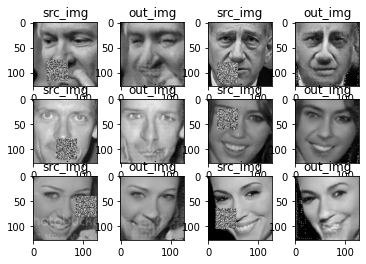

In [ ]:
# 效果展示
net = AutoEncoder()
# ckpt = osp.join(CHECKPOINT, "net.pth") # 普通AE
# ckpt = osp.join(CHECKPOINT, "G.pth") # 增加GAN的AE
ckpt = osp.join(CHECKPOINT, "G_fix.pth") # 圖型修復的AE
net.load_state_dict(torch.load(ckpt)) # 載入模型
net.eval()
for i in range(6):
    src, _ = val_data[i]
    img = transforms.ToPILImage()(src)
    print(i)
    plt.subplot(3, 4, (i + 1) * 2 - 1)
    plt.title("src_img")
    plt.imshow(img, cmap="gray")
    out = net(src.unsqueeze(0)).squeeze(0)
    out_img = transforms.ToPILImage()(out)
    plt.subplot(3, 4, (i + 1) * 2)
    plt.title("out_img")
    plt.imshow(out_img, cmap="gray")
    plt.savefig("auto_encoder_gan_fix_face.jpg")
plt.show()